[Episode 0] Steps: 100, Total attached: 96, Success: True


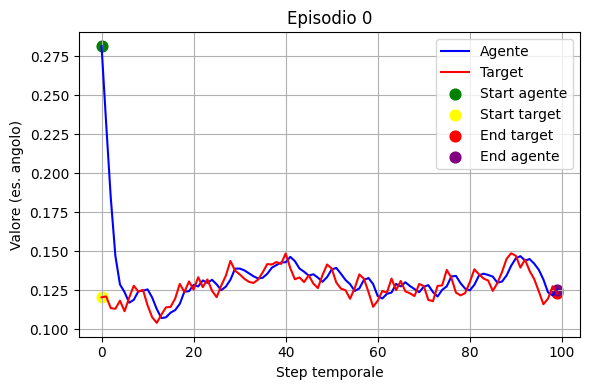

[Episode 1] Steps: 100, Total attached: 12, Success: False


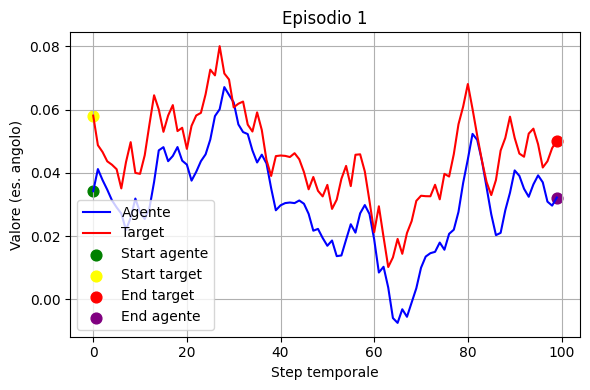

[Episode 2] Steps: 100, Total attached: 0, Success: False


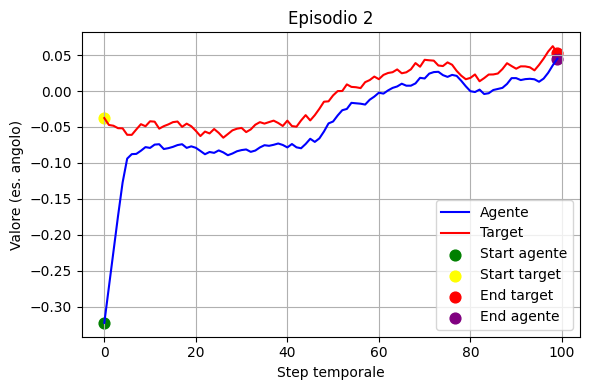

[Episode 3] Steps: 100, Total attached: 1, Success: False


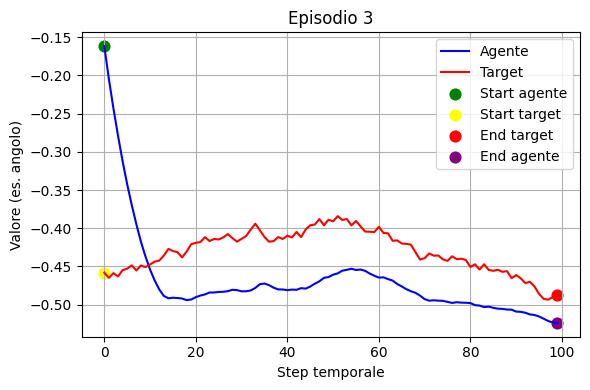

[Episode 4] Steps: 100, Total attached: 3, Success: False


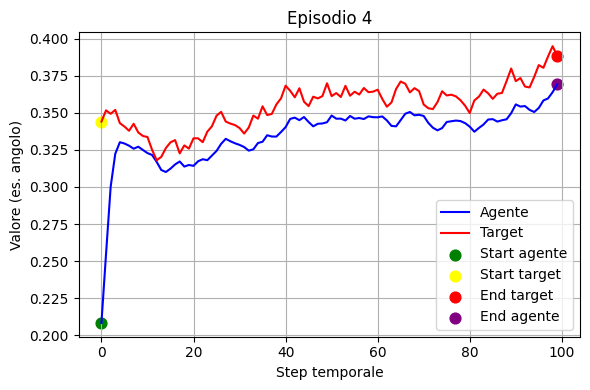

[Episode 5] Steps: 100, Total attached: 43, Success: False


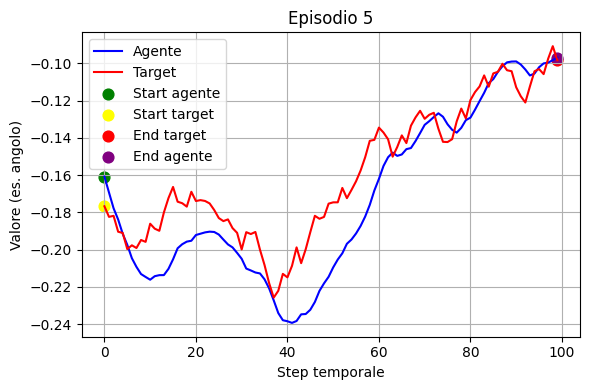

[Episode 6] Steps: 100, Total attached: 32, Success: False


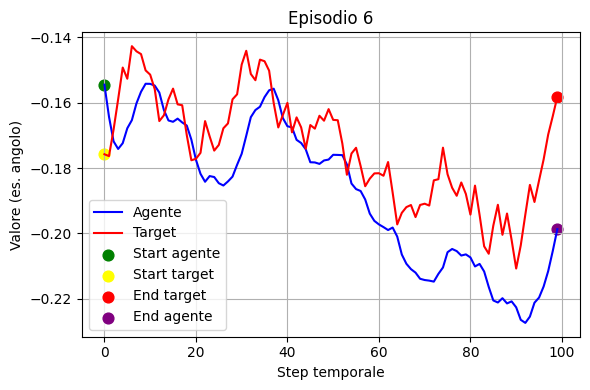

[Episode 7] Steps: 100, Total attached: 2, Success: False


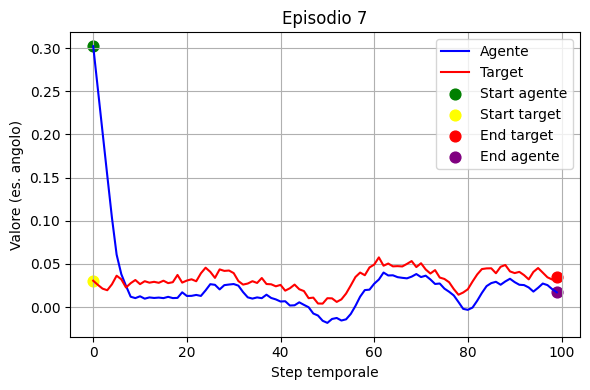

[Episode 8] Steps: 100, Total attached: 52, Success: False


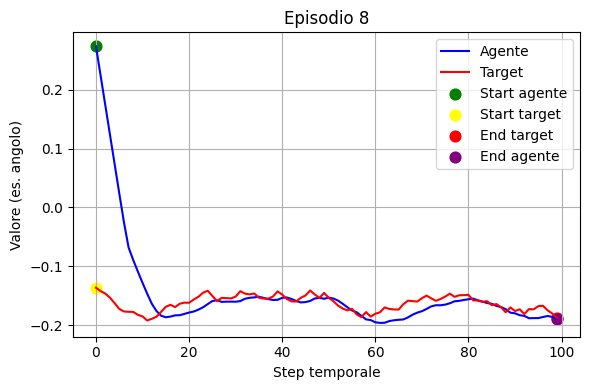

[Episode 9] Steps: 100, Total attached: 2, Success: False


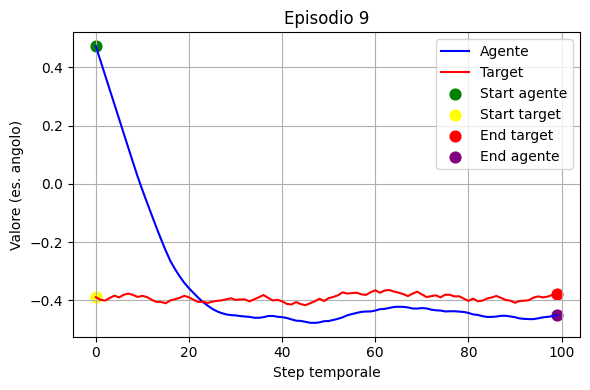


Media step attaccati: 24.30
Successi (attaccato per ≥ 20 step): 1 / 10


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path))
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=10, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            if torch.abs(real_next_state[0] - real_state[1]) < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = attached_counter > 80
        if success:
            success_counter += 1

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Success: {success}")

        # Plot
        trajectory = np.array(trajectory)
        target_trajectory = np.array(target_trajectory)
        plt.figure(figsize=(6, 4))
        plt.plot(trajectory, label="Agente", color='blue')
        plt.plot(target_trajectory, label="Target", color='red')
        plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
        plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
        plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
        plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
        plt.title(f"Episodio {ep}")
        plt.xlabel("Step temporale")
        plt.ylabel("Valore (es. angolo)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    env.close()
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 20 step): {success_counter} / {num_episodes}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward.zip"
    reward_path = "IL/DME_SAC/reward_network.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)


[Episode 0] Steps: 100, Total attached: 0, Mean distance: 0.0405, Success: False


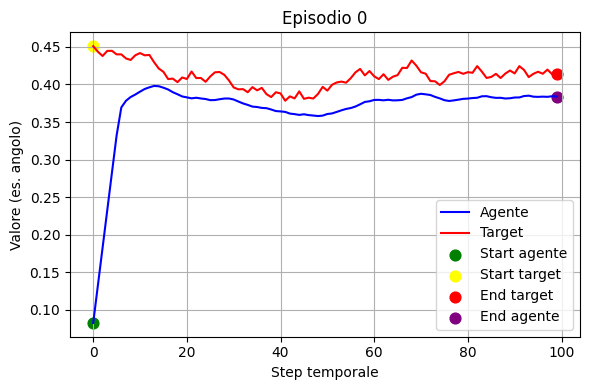

[Episode 1] Steps: 100, Total attached: 39, Mean distance: 0.0341, Success: False


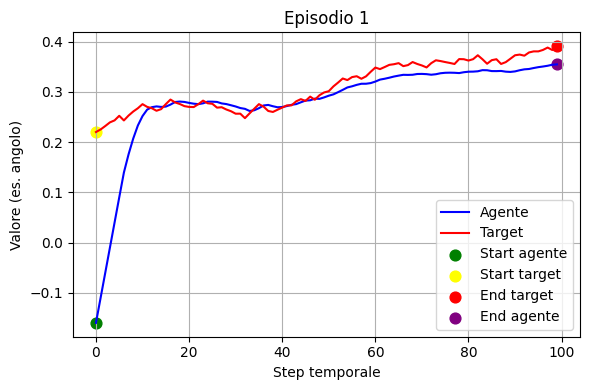

[Episode 2] Steps: 100, Total attached: 11, Mean distance: 0.0294, Success: False


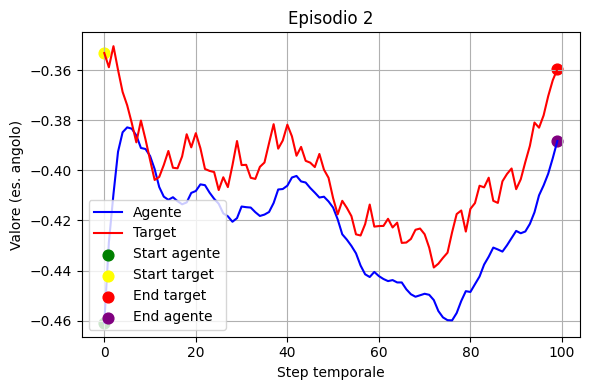

[Episode 3] Steps: 100, Total attached: 16, Mean distance: 0.0415, Success: False


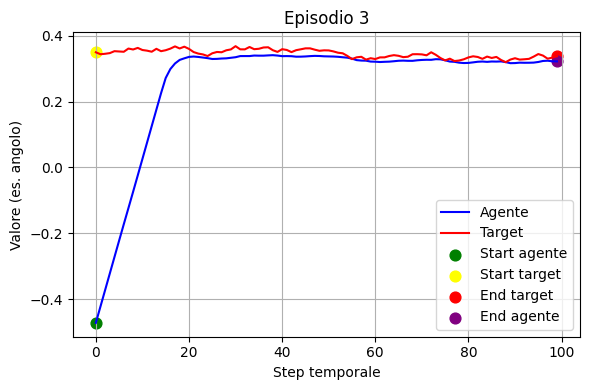

[Episode 4] Steps: 100, Total attached: 72, Mean distance: 0.0451, Success: False


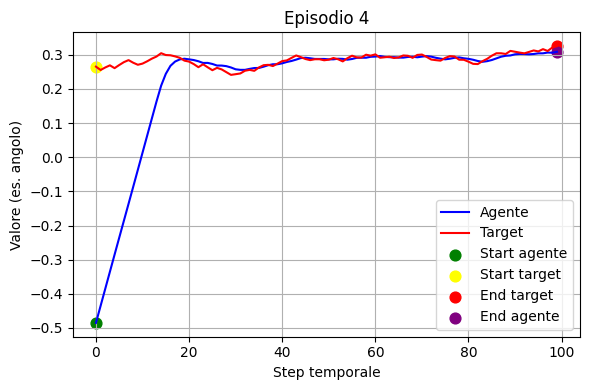

[Episode 5] Steps: 100, Total attached: 67, Mean distance: 0.0391, Success: False


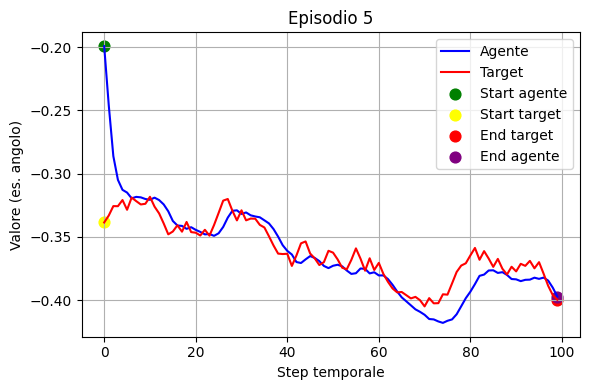

[Episode 6] Steps: 100, Total attached: 0, Mean distance: 0.0439, Success: False


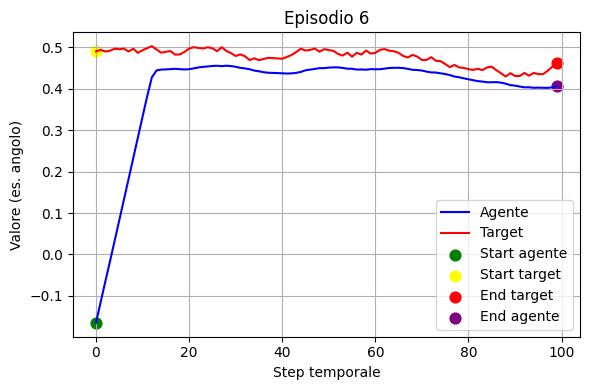

[Episode 7] Steps: 100, Total attached: 78, Mean distance: 0.0414, Success: False


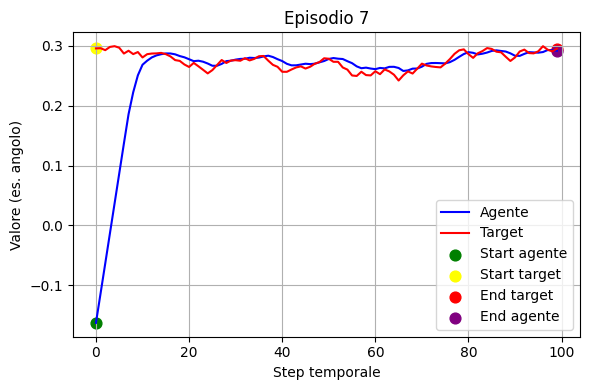

[Episode 8] Steps: 100, Total attached: 49, Mean distance: 0.0384, Success: False


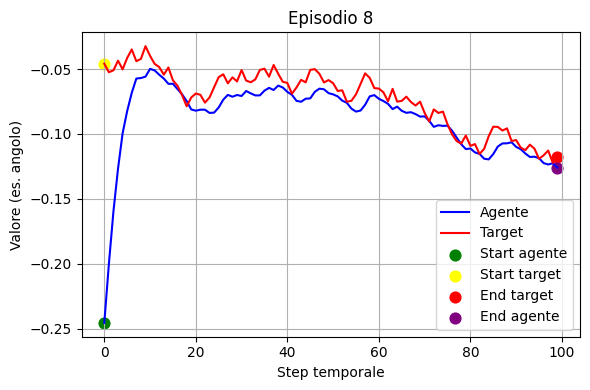

[Episode 9] Steps: 100, Total attached: 41, Mean distance: 0.0356, Success: False


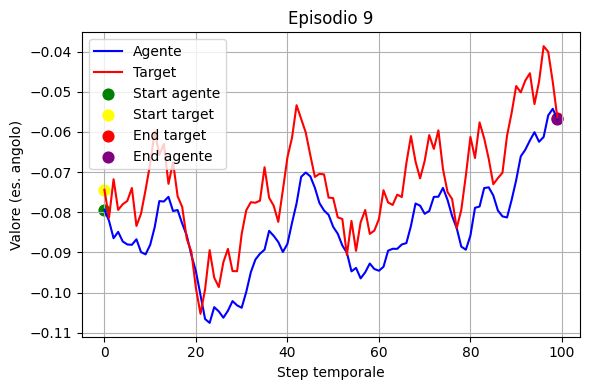


Media step attaccati: 37.30
Successi (attaccato per ≥ 80 step): 0 / 10
Media distanza episodio: 0.0389


In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path))
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=10, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.abs(real_next_state[0] - real_state[1])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        trajectory = np.array(trajectory)
        target_trajectory = np.array(target_trajectory)
        plt.figure(figsize=(6, 4))
        plt.plot(trajectory, label="Agente", color='blue')
        plt.plot(target_trajectory, label="Target", color='red')
        plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
        plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
        plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
        plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
        plt.title(f"Episodio {ep}")
        plt.xlabel("Step temporale")
        plt.ylabel("Valore (es. angolo)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_rot_0.5_0.01"
    reward_path = "IL/DME_SAC/reward_network.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)


[Episode 0] Steps: 100, Total attached: 94, Mean distance: 0.0116, Success: True


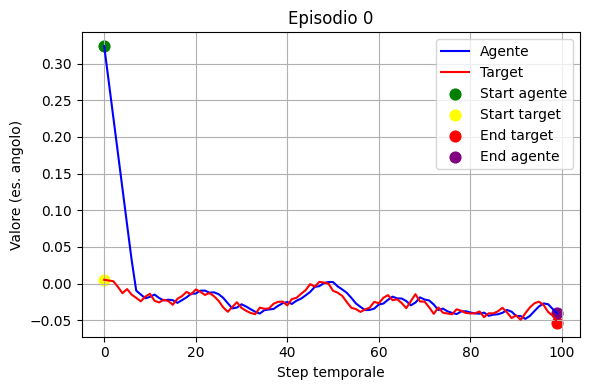

[Episode 1] Steps: 100, Total attached: 92, Mean distance: 0.0152, Success: True
[Episode 2] Steps: 100, Total attached: 92, Mean distance: 0.0157, Success: True
[Episode 3] Steps: 100, Total attached: 95, Mean distance: 0.0138, Success: True
[Episode 4] Steps: 100, Total attached: 99, Mean distance: 0.0116, Success: True
[Episode 5] Steps: 100, Total attached: 94, Mean distance: 0.0108, Success: True
[Episode 6] Steps: 100, Total attached: 100, Mean distance: 0.0097, Success: True
[Episode 7] Steps: 100, Total attached: 82, Mean distance: 0.0189, Success: True
[Episode 8] Steps: 100, Total attached: 99, Mean distance: 0.0169, Success: True
[Episode 9] Steps: 100, Total attached: 97, Mean distance: 0.0156, Success: True
[Episode 10] Steps: 100, Total attached: 82, Mean distance: 0.0151, Success: True
[Episode 11] Steps: 100, Total attached: 95, Mean distance: 0.0142, Success: True
[Episode 12] Steps: 100, Total attached: 99, Mean distance: 0.0134, Success: True
[Episode 13] Steps: 100,

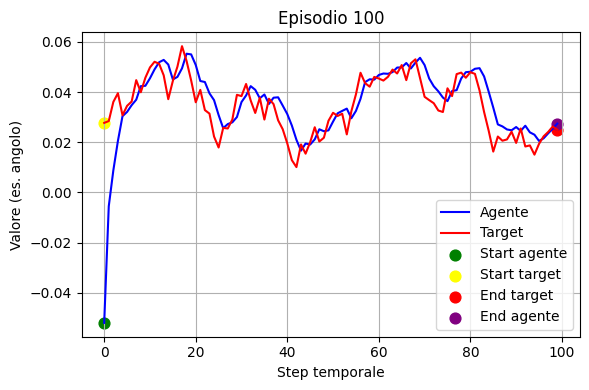

[Episode 101] Steps: 100, Total attached: 95, Mean distance: 0.0205, Success: True
[Episode 102] Steps: 100, Total attached: 93, Mean distance: 0.0204, Success: True
[Episode 103] Steps: 100, Total attached: 84, Mean distance: 0.0205, Success: True
[Episode 104] Steps: 100, Total attached: 90, Mean distance: 0.0206, Success: True
[Episode 105] Steps: 100, Total attached: 85, Mean distance: 0.0206, Success: True
[Episode 106] Steps: 100, Total attached: 84, Mean distance: 0.0209, Success: True
[Episode 107] Steps: 100, Total attached: 94, Mean distance: 0.0208, Success: True
[Episode 108] Steps: 100, Total attached: 92, Mean distance: 0.0208, Success: True
[Episode 109] Steps: 100, Total attached: 94, Mean distance: 0.0207, Success: True
[Episode 110] Steps: 100, Total attached: 87, Mean distance: 0.0207, Success: True
[Episode 111] Steps: 100, Total attached: 77, Mean distance: 0.0208, Success: False
[Episode 112] Steps: 100, Total attached: 88, Mean distance: 0.0210, Success: True
[Ep

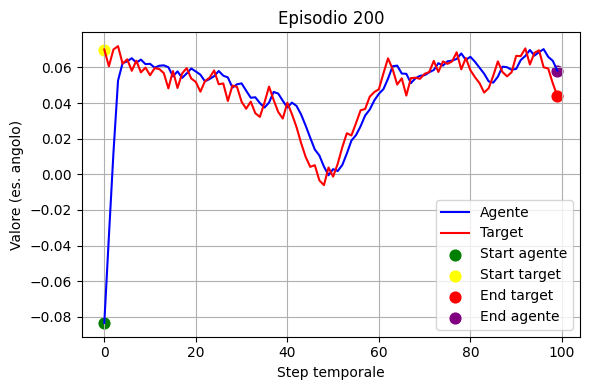

[Episode 201] Steps: 100, Total attached: 97, Mean distance: 0.0184, Success: True
[Episode 202] Steps: 100, Total attached: 79, Mean distance: 0.0188, Success: False
[Episode 203] Steps: 100, Total attached: 91, Mean distance: 0.0188, Success: True
[Episode 204] Steps: 100, Total attached: 99, Mean distance: 0.0187, Success: True
[Episode 205] Steps: 100, Total attached: 85, Mean distance: 0.0188, Success: True
[Episode 206] Steps: 100, Total attached: 81, Mean distance: 0.0188, Success: True
[Episode 207] Steps: 100, Total attached: 81, Mean distance: 0.0188, Success: True
[Episode 208] Steps: 100, Total attached: 97, Mean distance: 0.0187, Success: True
[Episode 209] Steps: 100, Total attached: 99, Mean distance: 0.0187, Success: True
[Episode 210] Steps: 100, Total attached: 94, Mean distance: 0.0186, Success: True
[Episode 211] Steps: 100, Total attached: 100, Mean distance: 0.0185, Success: True
[Episode 212] Steps: 100, Total attached: 95, Mean distance: 0.0185, Success: True
[E

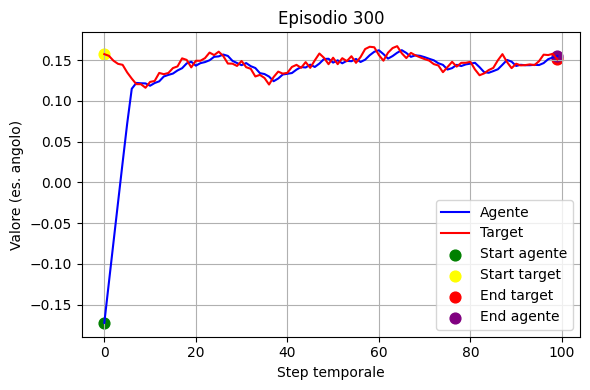

[Episode 301] Steps: 100, Total attached: 87, Mean distance: 0.0191, Success: True
[Episode 302] Steps: 100, Total attached: 95, Mean distance: 0.0191, Success: True
[Episode 303] Steps: 100, Total attached: 80, Mean distance: 0.0190, Success: False
[Episode 304] Steps: 100, Total attached: 91, Mean distance: 0.0190, Success: True
[Episode 305] Steps: 100, Total attached: 97, Mean distance: 0.0190, Success: True
[Episode 306] Steps: 100, Total attached: 86, Mean distance: 0.0189, Success: True
[Episode 307] Steps: 100, Total attached: 87, Mean distance: 0.0190, Success: True
[Episode 308] Steps: 100, Total attached: 88, Mean distance: 0.0190, Success: True
[Episode 309] Steps: 100, Total attached: 91, Mean distance: 0.0190, Success: True
[Episode 310] Steps: 100, Total attached: 82, Mean distance: 0.0190, Success: True
[Episode 311] Steps: 100, Total attached: 90, Mean distance: 0.0190, Success: True
[Episode 312] Steps: 100, Total attached: 100, Mean distance: 0.0189, Success: True
[E

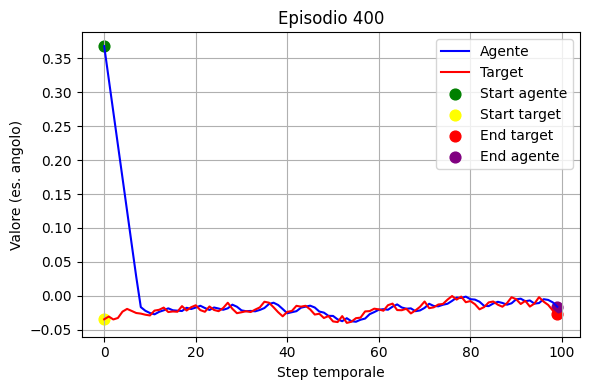

[Episode 401] Steps: 100, Total attached: 100, Mean distance: 0.0192, Success: True
[Episode 402] Steps: 100, Total attached: 92, Mean distance: 0.0192, Success: True
[Episode 403] Steps: 100, Total attached: 98, Mean distance: 0.0192, Success: True
[Episode 404] Steps: 100, Total attached: 73, Mean distance: 0.0194, Success: False
[Episode 405] Steps: 100, Total attached: 94, Mean distance: 0.0193, Success: True
[Episode 406] Steps: 100, Total attached: 97, Mean distance: 0.0193, Success: True
[Episode 407] Steps: 100, Total attached: 82, Mean distance: 0.0194, Success: True
[Episode 408] Steps: 100, Total attached: 99, Mean distance: 0.0194, Success: True
[Episode 409] Steps: 100, Total attached: 84, Mean distance: 0.0195, Success: True
[Episode 410] Steps: 100, Total attached: 98, Mean distance: 0.0194, Success: True
[Episode 411] Steps: 100, Total attached: 94, Mean distance: 0.0194, Success: True
[Episode 412] Steps: 100, Total attached: 96, Mean distance: 0.0194, Success: True
[E

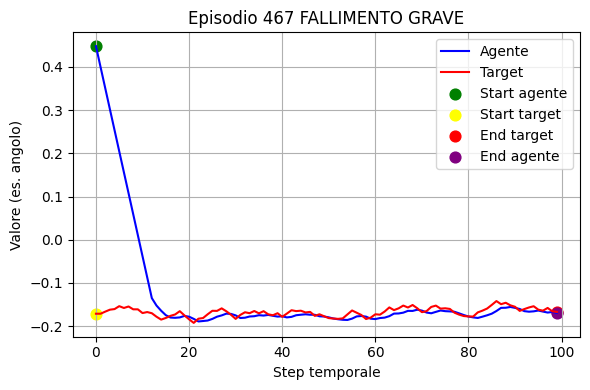

[Episode 467] Steps: 100, Total attached: 67, Mean distance: 0.0191, Success: False
[Episode 468] Steps: 100, Total attached: 93, Mean distance: 0.0191, Success: True
[Episode 469] Steps: 100, Total attached: 81, Mean distance: 0.0192, Success: True
[Episode 470] Steps: 100, Total attached: 92, Mean distance: 0.0192, Success: True
[Episode 471] Steps: 100, Total attached: 93, Mean distance: 0.0192, Success: True
[Episode 472] Steps: 100, Total attached: 94, Mean distance: 0.0191, Success: True
[Episode 473] Steps: 100, Total attached: 99, Mean distance: 0.0191, Success: True
[Episode 474] Steps: 100, Total attached: 71, Mean distance: 0.0191, Success: False
[Episode 475] Steps: 100, Total attached: 94, Mean distance: 0.0191, Success: True
[Episode 476] Steps: 100, Total attached: 75, Mean distance: 0.0191, Success: False
[Episode 477] Steps: 100, Total attached: 97, Mean distance: 0.0191, Success: True
[Episode 478] Steps: 100, Total attached: 98, Mean distance: 0.0190, Success: True
[

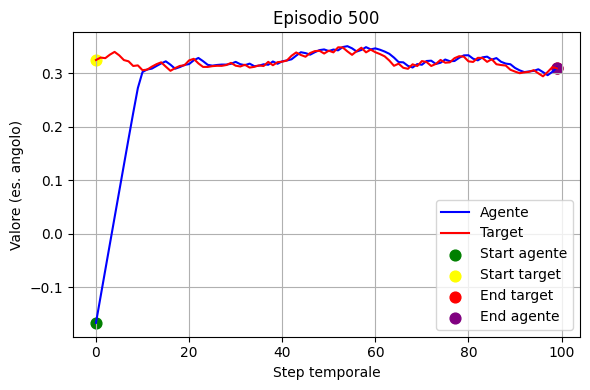

[Episode 501] Steps: 100, Total attached: 79, Mean distance: 0.0192, Success: False
[Episode 502] Steps: 100, Total attached: 97, Mean distance: 0.0192, Success: True
[Episode 503] Steps: 100, Total attached: 97, Mean distance: 0.0191, Success: True
[Episode 504] Steps: 100, Total attached: 96, Mean distance: 0.0191, Success: True
[Episode 505] Steps: 100, Total attached: 90, Mean distance: 0.0191, Success: True
[Episode 506] Steps: 100, Total attached: 88, Mean distance: 0.0191, Success: True
[Episode 507] Steps: 100, Total attached: 75, Mean distance: 0.0191, Success: False
[Episode 508] Steps: 100, Total attached: 98, Mean distance: 0.0191, Success: True
[Episode 509] Steps: 100, Total attached: 92, Mean distance: 0.0191, Success: True
[Episode 510] Steps: 100, Total attached: 80, Mean distance: 0.0191, Success: False
[Episode 511] Steps: 100, Total attached: 91, Mean distance: 0.0191, Success: True
[Episode 512] Steps: 100, Total attached: 87, Mean distance: 0.0191, Success: True
[

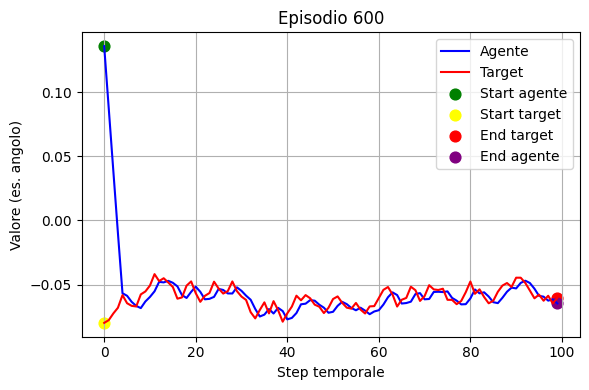

[Episode 601] Steps: 100, Total attached: 97, Mean distance: 0.0191, Success: True
[Episode 602] Steps: 100, Total attached: 93, Mean distance: 0.0191, Success: True
[Episode 603] Steps: 100, Total attached: 100, Mean distance: 0.0191, Success: True
[Episode 604] Steps: 100, Total attached: 88, Mean distance: 0.0191, Success: True
[Episode 605] Steps: 100, Total attached: 89, Mean distance: 0.0191, Success: True
[Episode 606] Steps: 100, Total attached: 92, Mean distance: 0.0191, Success: True
[Episode 607] Steps: 100, Total attached: 90, Mean distance: 0.0191, Success: True
[Episode 608] Steps: 100, Total attached: 96, Mean distance: 0.0191, Success: True
[Episode 609] Steps: 100, Total attached: 92, Mean distance: 0.0191, Success: True
[Episode 610] Steps: 100, Total attached: 90, Mean distance: 0.0191, Success: True
[Episode 611] Steps: 100, Total attached: 87, Mean distance: 0.0191, Success: True
[Episode 612] Steps: 100, Total attached: 87, Mean distance: 0.0191, Success: True
[Ep

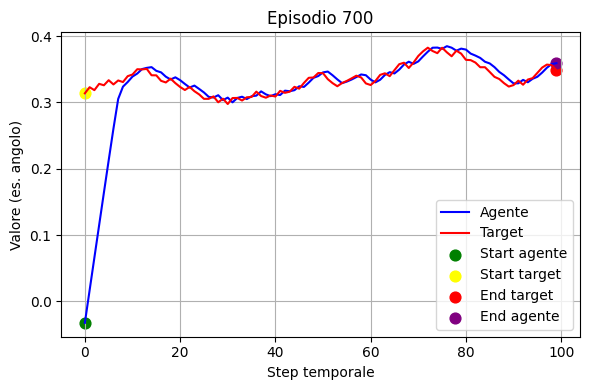

[Episode 701] Steps: 100, Total attached: 88, Mean distance: 0.0190, Success: True
[Episode 702] Steps: 100, Total attached: 100, Mean distance: 0.0190, Success: True
[Episode 703] Steps: 100, Total attached: 88, Mean distance: 0.0190, Success: True
[Episode 704] Steps: 100, Total attached: 86, Mean distance: 0.0191, Success: True
[Episode 705] Steps: 100, Total attached: 99, Mean distance: 0.0190, Success: True
[Episode 706] Steps: 100, Total attached: 94, Mean distance: 0.0190, Success: True
[Episode 707] Steps: 100, Total attached: 88, Mean distance: 0.0190, Success: True
[Episode 708] Steps: 100, Total attached: 95, Mean distance: 0.0190, Success: True
[Episode 709] Steps: 100, Total attached: 93, Mean distance: 0.0190, Success: True
[Episode 710] Steps: 100, Total attached: 91, Mean distance: 0.0190, Success: True
[Episode 711] Steps: 100, Total attached: 74, Mean distance: 0.0190, Success: False
[Episode 712] Steps: 100, Total attached: 86, Mean distance: 0.0190, Success: True
[E

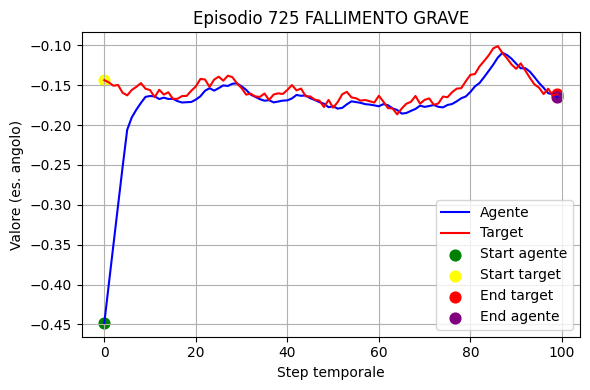

[Episode 725] Steps: 100, Total attached: 67, Mean distance: 0.0192, Success: False
[Episode 726] Steps: 100, Total attached: 97, Mean distance: 0.0192, Success: True
[Episode 727] Steps: 100, Total attached: 88, Mean distance: 0.0192, Success: True
[Episode 728] Steps: 100, Total attached: 81, Mean distance: 0.0193, Success: True
[Episode 729] Steps: 100, Total attached: 84, Mean distance: 0.0193, Success: True
[Episode 730] Steps: 100, Total attached: 90, Mean distance: 0.0193, Success: True
[Episode 731] Steps: 100, Total attached: 90, Mean distance: 0.0193, Success: True
[Episode 732] Steps: 100, Total attached: 80, Mean distance: 0.0193, Success: False
[Episode 733] Steps: 100, Total attached: 96, Mean distance: 0.0192, Success: True
[Episode 734] Steps: 100, Total attached: 99, Mean distance: 0.0192, Success: True
[Episode 735] Steps: 100, Total attached: 94, Mean distance: 0.0192, Success: True
[Episode 736] Steps: 100, Total attached: 84, Mean distance: 0.0193, Success: True
[E

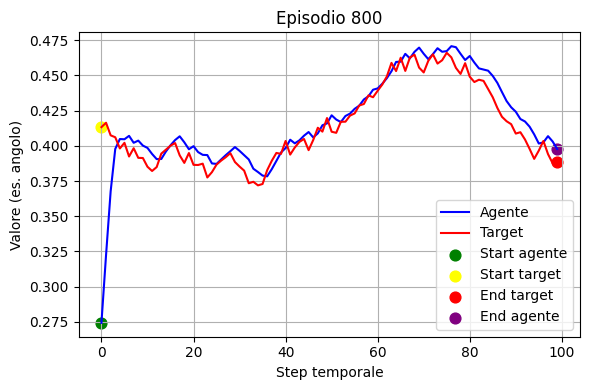

[Episode 801] Steps: 100, Total attached: 81, Mean distance: 0.0191, Success: True
[Episode 802] Steps: 100, Total attached: 88, Mean distance: 0.0191, Success: True
[Episode 803] Steps: 100, Total attached: 84, Mean distance: 0.0192, Success: True
[Episode 804] Steps: 100, Total attached: 94, Mean distance: 0.0192, Success: True
[Episode 805] Steps: 100, Total attached: 96, Mean distance: 0.0192, Success: True
[Episode 806] Steps: 100, Total attached: 79, Mean distance: 0.0192, Success: False
[Episode 807] Steps: 100, Total attached: 93, Mean distance: 0.0192, Success: True
[Episode 808] Steps: 100, Total attached: 82, Mean distance: 0.0192, Success: True
[Episode 809] Steps: 100, Total attached: 92, Mean distance: 0.0192, Success: True
[Episode 810] Steps: 100, Total attached: 87, Mean distance: 0.0193, Success: True
[Episode 811] Steps: 100, Total attached: 90, Mean distance: 0.0193, Success: True
[Episode 812] Steps: 100, Total attached: 90, Mean distance: 0.0193, Success: True
[Ep

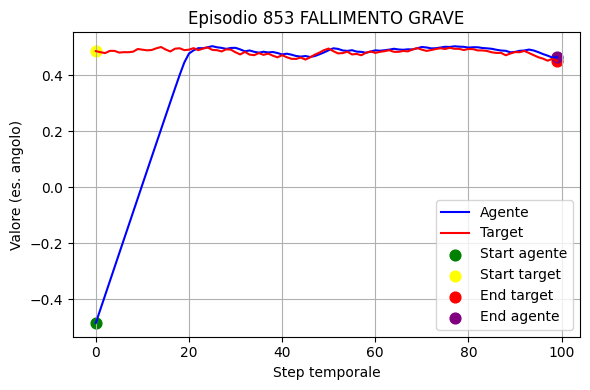

[Episode 853] Steps: 100, Total attached: 69, Mean distance: 0.0193, Success: False
[Episode 854] Steps: 100, Total attached: 98, Mean distance: 0.0193, Success: True
[Episode 855] Steps: 100, Total attached: 89, Mean distance: 0.0193, Success: True
[Episode 856] Steps: 100, Total attached: 84, Mean distance: 0.0193, Success: True
[Episode 857] Steps: 100, Total attached: 96, Mean distance: 0.0193, Success: True
[Episode 858] Steps: 100, Total attached: 87, Mean distance: 0.0193, Success: True
[Episode 859] Steps: 100, Total attached: 97, Mean distance: 0.0193, Success: True
[Episode 860] Steps: 100, Total attached: 78, Mean distance: 0.0193, Success: False
[Episode 861] Steps: 100, Total attached: 93, Mean distance: 0.0193, Success: True
[Episode 862] Steps: 100, Total attached: 94, Mean distance: 0.0193, Success: True
[Episode 863] Steps: 100, Total attached: 94, Mean distance: 0.0193, Success: True
[Episode 864] Steps: 100, Total attached: 96, Mean distance: 0.0193, Success: True
[E

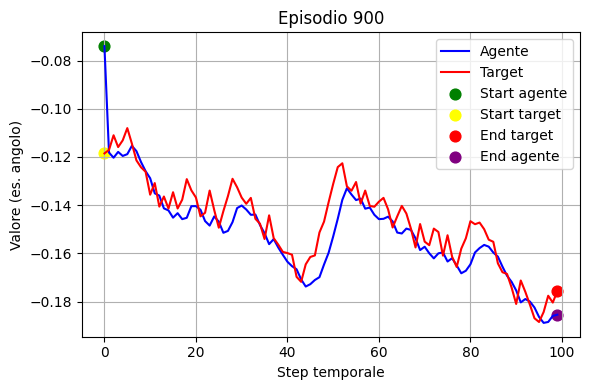

[Episode 901] Steps: 100, Total attached: 97, Mean distance: 0.0191, Success: True
[Episode 902] Steps: 100, Total attached: 94, Mean distance: 0.0191, Success: True
[Episode 903] Steps: 100, Total attached: 77, Mean distance: 0.0192, Success: False
[Episode 904] Steps: 100, Total attached: 98, Mean distance: 0.0191, Success: True
[Episode 905] Steps: 100, Total attached: 80, Mean distance: 0.0192, Success: False
[Episode 906] Steps: 100, Total attached: 95, Mean distance: 0.0192, Success: True
[Episode 907] Steps: 100, Total attached: 72, Mean distance: 0.0192, Success: False
[Episode 908] Steps: 100, Total attached: 88, Mean distance: 0.0192, Success: True
[Episode 909] Steps: 100, Total attached: 95, Mean distance: 0.0192, Success: True
[Episode 910] Steps: 100, Total attached: 90, Mean distance: 0.0192, Success: True
[Episode 911] Steps: 100, Total attached: 84, Mean distance: 0.0192, Success: True
[Episode 912] Steps: 100, Total attached: 83, Mean distance: 0.0192, Success: True
[

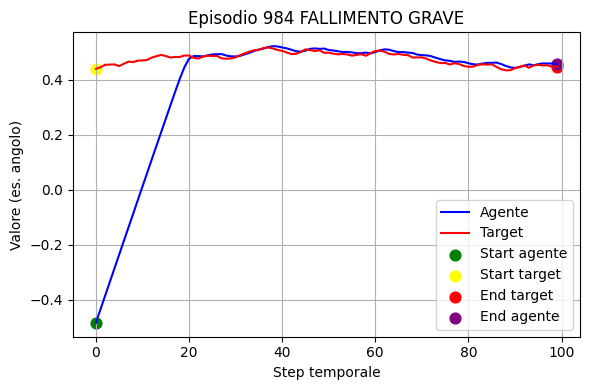

[Episode 984] Steps: 100, Total attached: 69, Mean distance: 0.0196, Success: False
[Episode 985] Steps: 100, Total attached: 97, Mean distance: 0.0196, Success: True
[Episode 986] Steps: 100, Total attached: 76, Mean distance: 0.0196, Success: False
[Episode 987] Steps: 100, Total attached: 86, Mean distance: 0.0196, Success: True
[Episode 988] Steps: 100, Total attached: 93, Mean distance: 0.0196, Success: True
[Episode 989] Steps: 100, Total attached: 86, Mean distance: 0.0196, Success: True
[Episode 990] Steps: 100, Total attached: 92, Mean distance: 0.0196, Success: True
[Episode 991] Steps: 100, Total attached: 99, Mean distance: 0.0196, Success: True
[Episode 992] Steps: 100, Total attached: 98, Mean distance: 0.0196, Success: True
[Episode 993] Steps: 100, Total attached: 88, Mean distance: 0.0196, Success: True
[Episode 994] Steps: 100, Total attached: 93, Mean distance: 0.0196, Success: True
[Episode 995] Steps: 100, Total attached: 95, Mean distance: 0.0196, Success: True
[E

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    device = torch.device("cpu")
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path, map_location=device))
    reward_net.to(device)
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=1000, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []
    fail = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.abs(real_next_state[0] - real_state[1])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        if total_attached_counter < 70:
            fail += 1
            print(f"Fail episode {ep} with total attached: {total_attached_counter}")
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep} FALLIMENTO GRAVE")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep}")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")
    print(f"Fallimenti gravi (attaccato < 70 step): {fail} / {num_episodes}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_rot_0.5_0.01_IRL"
    reward_path = "IL/DME_SAC/reward_network_rot_0.5_0.01.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)


Fail episode 0 with total attached: 0


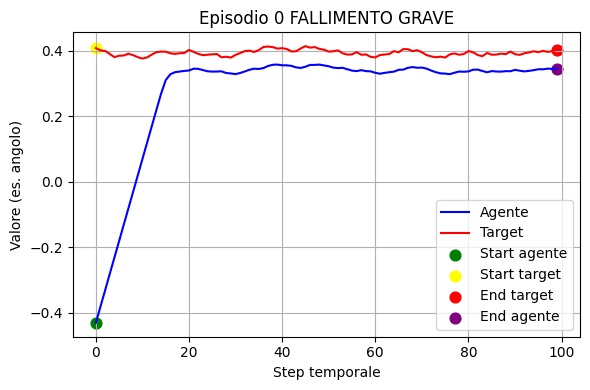

[Episode 0] Steps: 100, Total attached: 0, Mean distance: 0.1081, Success: False


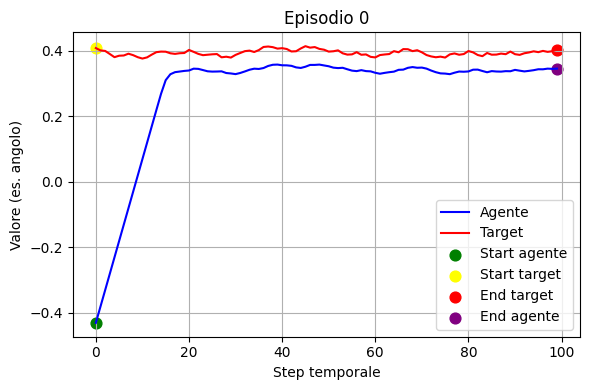

Fail episode 1 with total attached: 0


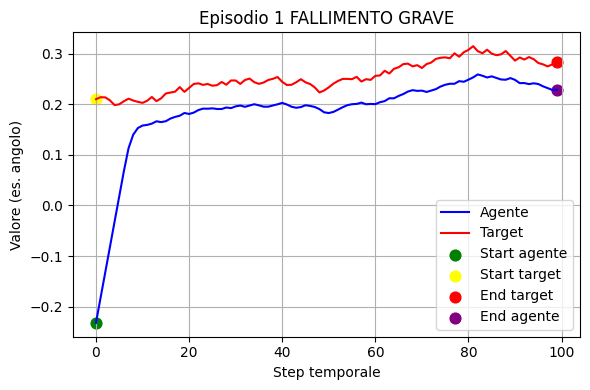

[Episode 1] Steps: 100, Total attached: 0, Mean distance: 0.0854, Success: False
Fail episode 2 with total attached: 0


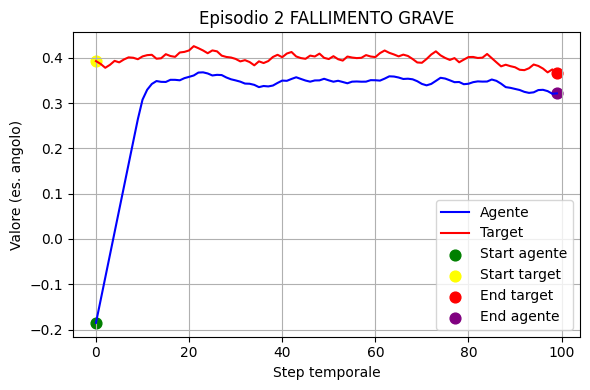

[Episode 2] Steps: 100, Total attached: 0, Mean distance: 0.0828, Success: False
Fail episode 3 with total attached: 0


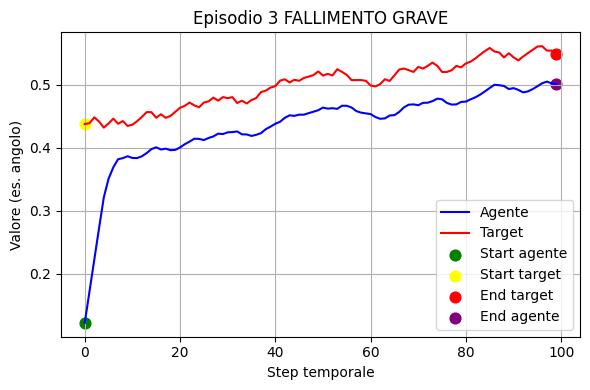

[Episode 3] Steps: 100, Total attached: 0, Mean distance: 0.0773, Success: False
Fail episode 4 with total attached: 1


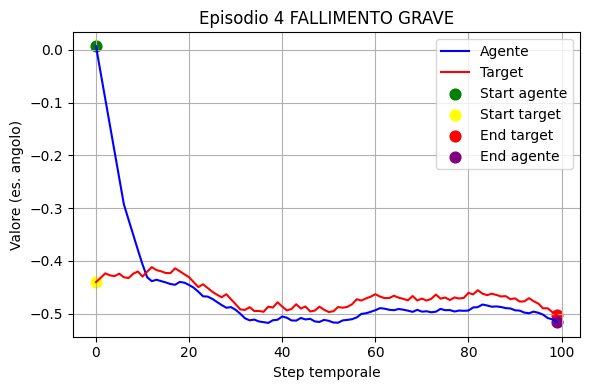

[Episode 4] Steps: 100, Total attached: 1, Mean distance: 0.0695, Success: False
Fail episode 5 with total attached: 2


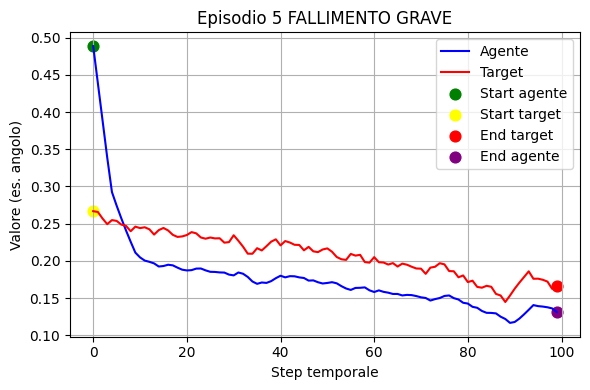

[Episode 5] Steps: 100, Total attached: 2, Mean distance: 0.0650, Success: False
Fail episode 6 with total attached: 48


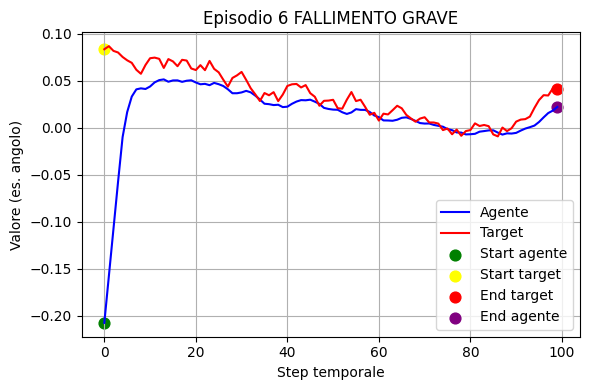

[Episode 6] Steps: 100, Total attached: 48, Mean distance: 0.0583, Success: False
Fail episode 7 with total attached: 0


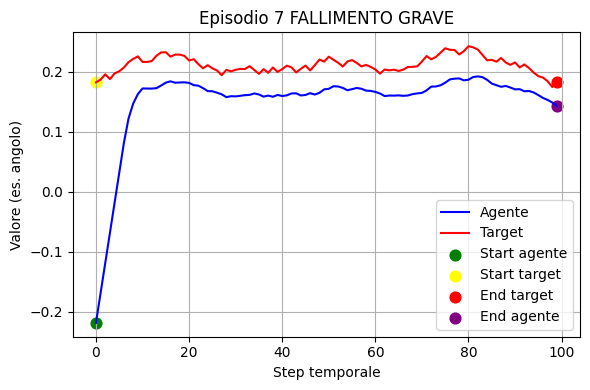

[Episode 7] Steps: 100, Total attached: 0, Mean distance: 0.0580, Success: False
Fail episode 8 with total attached: 1


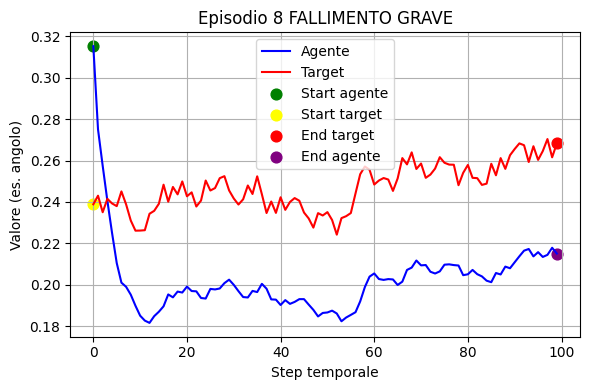

[Episode 8] Steps: 100, Total attached: 1, Mean distance: 0.0567, Success: False
[Episode 9] Steps: 100, Total attached: 77, Mean distance: 0.0519, Success: False
Fail episode 10 with total attached: 0


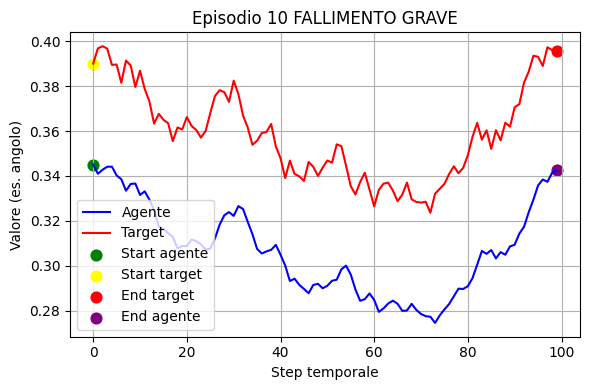

[Episode 10] Steps: 100, Total attached: 0, Mean distance: 0.0519, Success: False
Fail episode 11 with total attached: 0


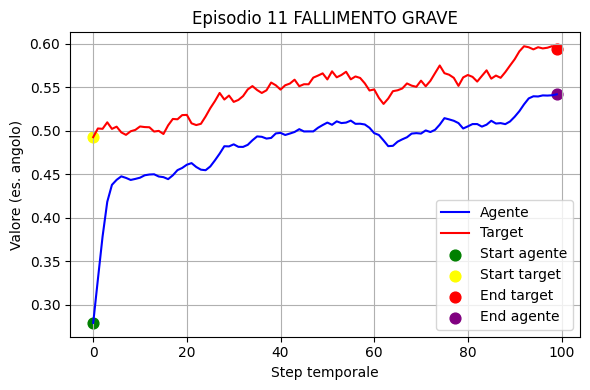

[Episode 11] Steps: 100, Total attached: 0, Mean distance: 0.0523, Success: False
Fail episode 12 with total attached: 3


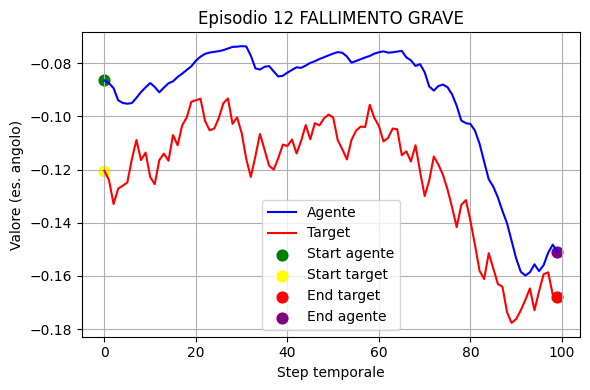

[Episode 12] Steps: 100, Total attached: 3, Mean distance: 0.0504, Success: False
Fail episode 13 with total attached: 1


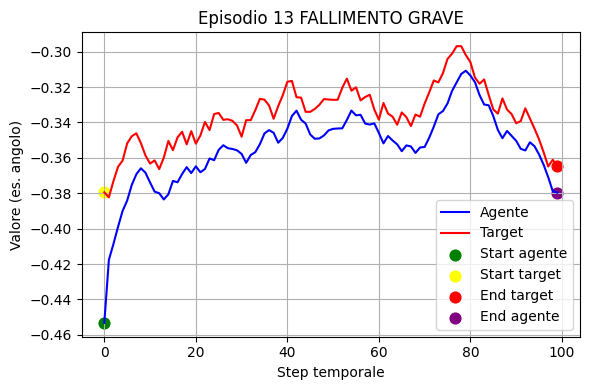

[Episode 13] Steps: 100, Total attached: 1, Mean distance: 0.0481, Success: False
Fail episode 14 with total attached: 6


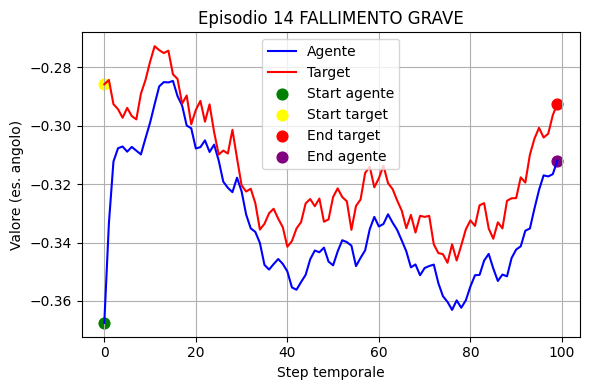

[Episode 14] Steps: 100, Total attached: 6, Mean distance: 0.0459, Success: False
Fail episode 15 with total attached: 7


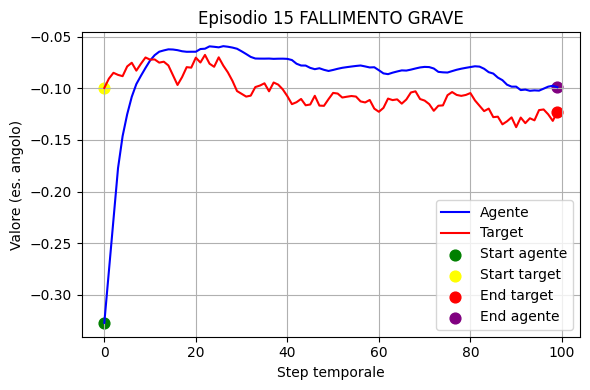

[Episode 15] Steps: 100, Total attached: 7, Mean distance: 0.0449, Success: False
Fail episode 16 with total attached: 38


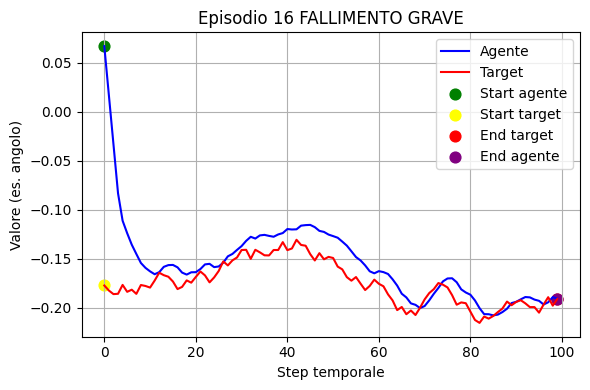

[Episode 16] Steps: 100, Total attached: 38, Mean distance: 0.0433, Success: False
Fail episode 17 with total attached: 1


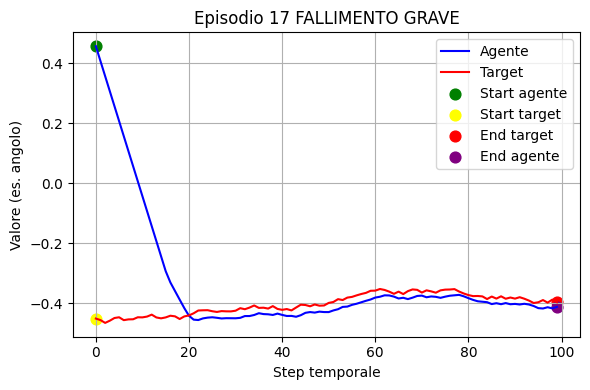

[Episode 17] Steps: 100, Total attached: 1, Mean distance: 0.0463, Success: False
Fail episode 18 with total attached: 0


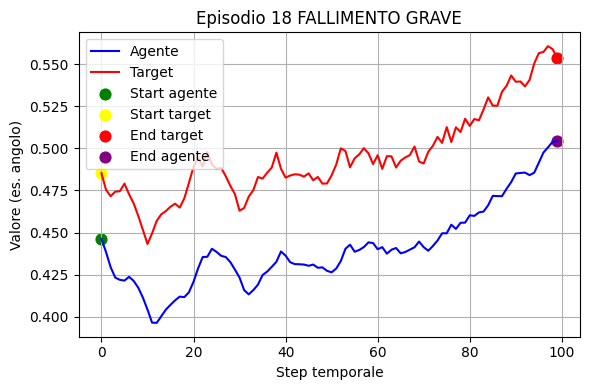

[Episode 18] Steps: 100, Total attached: 0, Mean distance: 0.0467, Success: False
Fail episode 19 with total attached: 2


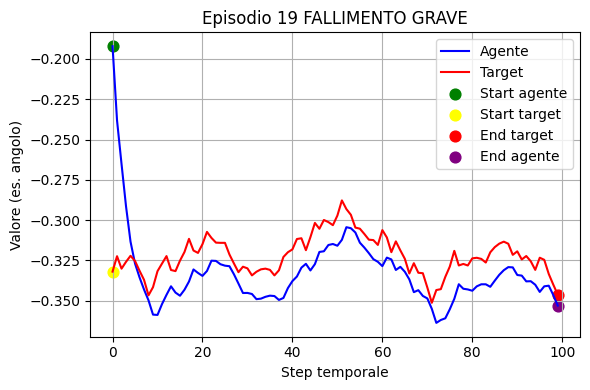

[Episode 19] Steps: 100, Total attached: 2, Mean distance: 0.0452, Success: False
Fail episode 20 with total attached: 17


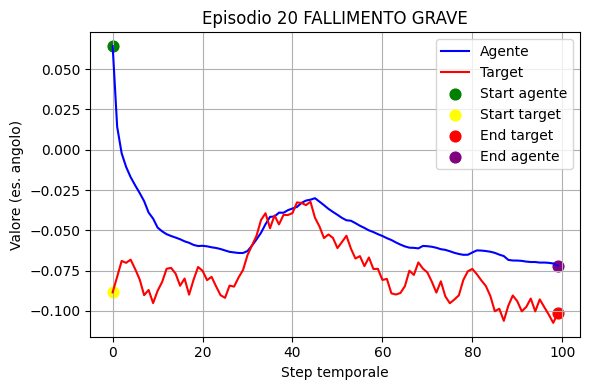

[Episode 20] Steps: 100, Total attached: 17, Mean distance: 0.0441, Success: False
Fail episode 21 with total attached: 1


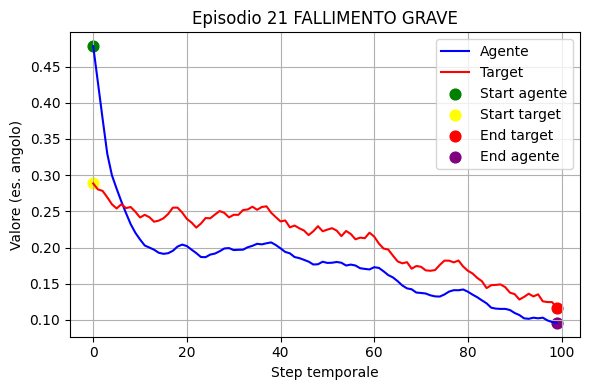

[Episode 21] Steps: 100, Total attached: 1, Mean distance: 0.0440, Success: False
Fail episode 22 with total attached: 63


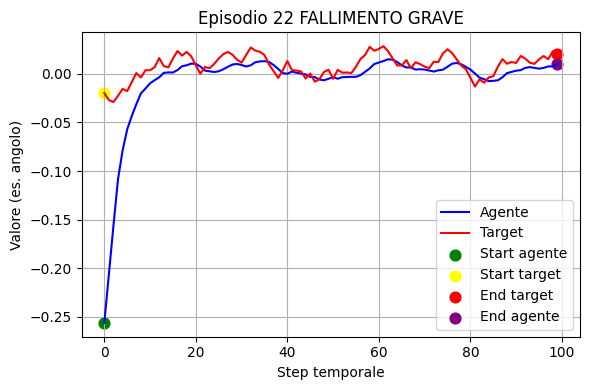

[Episode 22] Steps: 100, Total attached: 63, Mean distance: 0.0426, Success: False
Fail episode 23 with total attached: 0


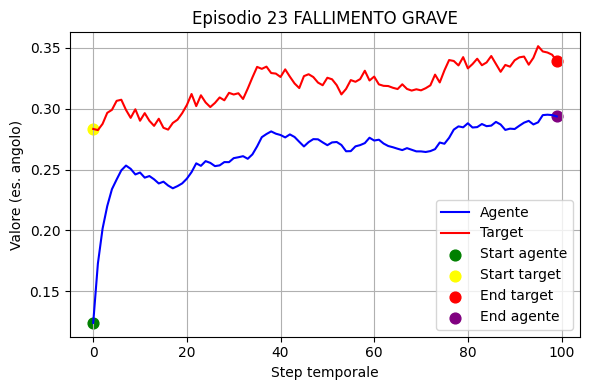

[Episode 23] Steps: 100, Total attached: 0, Mean distance: 0.0430, Success: False
Fail episode 24 with total attached: 0


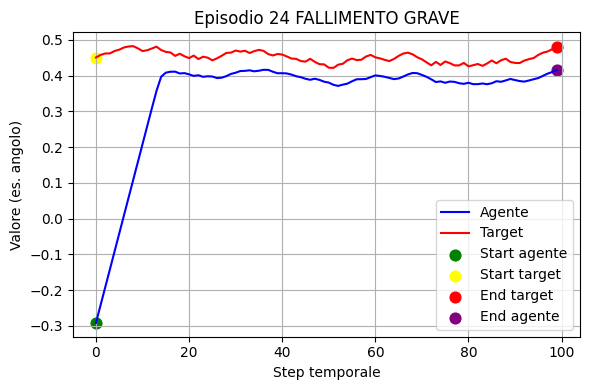

[Episode 24] Steps: 100, Total attached: 0, Mean distance: 0.0453, Success: False
Fail episode 25 with total attached: 0


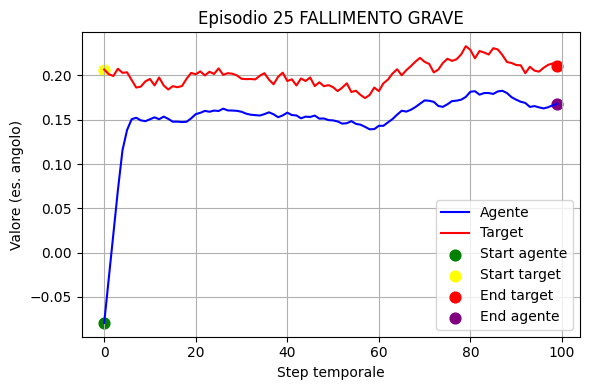

[Episode 25] Steps: 100, Total attached: 0, Mean distance: 0.0454, Success: False
[Episode 26] Steps: 100, Total attached: 71, Mean distance: 0.0443, Success: False
Fail episode 27 with total attached: 36


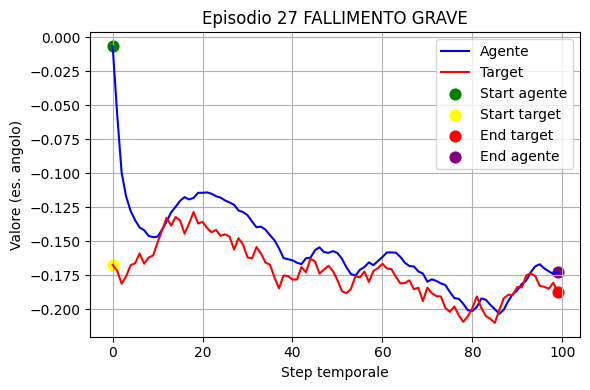

[Episode 27] Steps: 100, Total attached: 36, Mean distance: 0.0432, Success: False
Fail episode 28 with total attached: 24


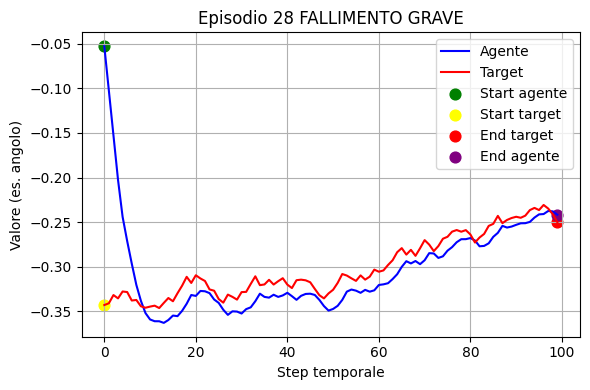

[Episode 28] Steps: 100, Total attached: 24, Mean distance: 0.0424, Success: False
[Episode 29] Steps: 100, Total attached: 84, Mean distance: 0.0412, Success: True
Fail episode 30 with total attached: 2


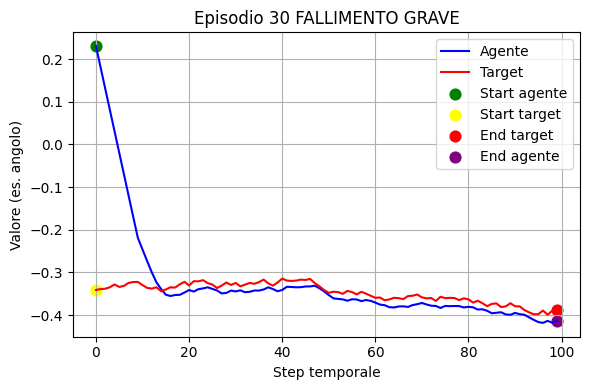

[Episode 30] Steps: 100, Total attached: 2, Mean distance: 0.0413, Success: False
Fail episode 31 with total attached: 1


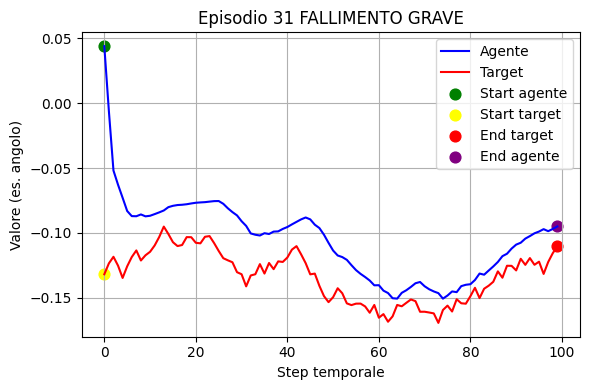

[Episode 31] Steps: 100, Total attached: 1, Mean distance: 0.0409, Success: False
Fail episode 32 with total attached: 0


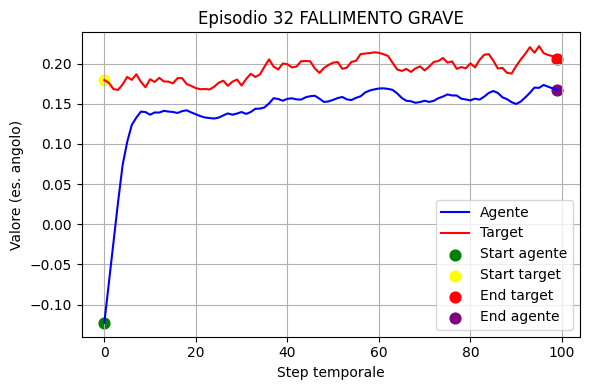

[Episode 32] Steps: 100, Total attached: 0, Mean distance: 0.0410, Success: False
Fail episode 33 with total attached: 53


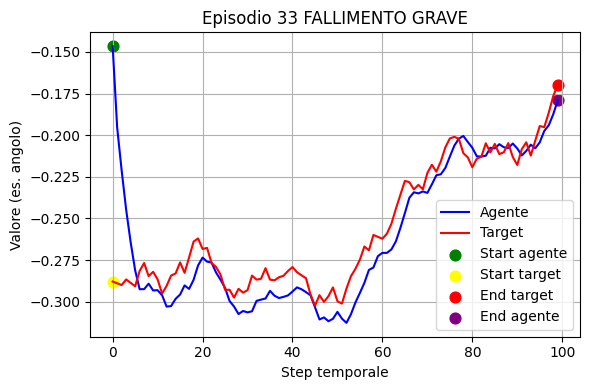

[Episode 33] Steps: 100, Total attached: 53, Mean distance: 0.0401, Success: False
Fail episode 34 with total attached: 0


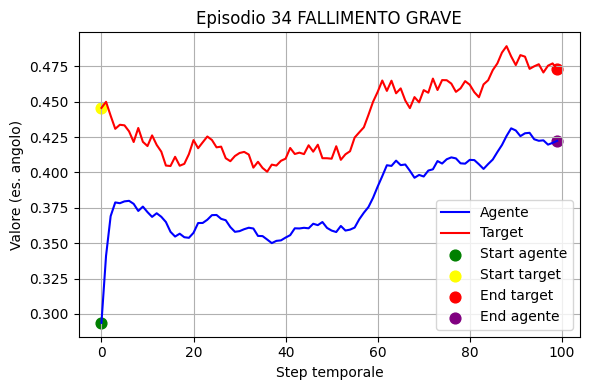

[Episode 34] Steps: 100, Total attached: 0, Mean distance: 0.0405, Success: False
Fail episode 35 with total attached: 6


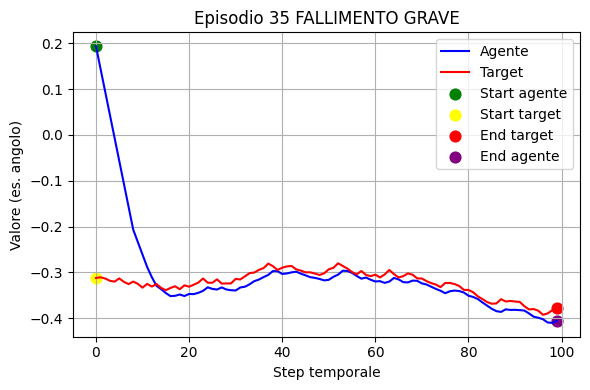

[Episode 35] Steps: 100, Total attached: 6, Mean distance: 0.0405, Success: False
Fail episode 36 with total attached: 8


KeyboardInterrupt: 

<Figure size 600x400 with 0 Axes>

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    device = torch.device("cpu")
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path, map_location=device))
    reward_net.to(device)
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=1000, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []
    fail = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.abs(real_next_state[0] - real_state[1])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        if total_attached_counter < 70:
            fail += 1
            print(f"Fail episode {ep} with total attached: {total_attached_counter}")
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep} FALLIMENTO GRAVE")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep}")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")
    print(f"Fallimenti gravi (attaccato < 70 step): {fail} / {num_episodes}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_rot_0.5_0.01"
    reward_path = "IL/DME_SAC/reward_network_rot_0.5_0.01.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)


[Episode 0] Steps: 100, Total attached: 97, Mean distance: 0.0041, Success: True


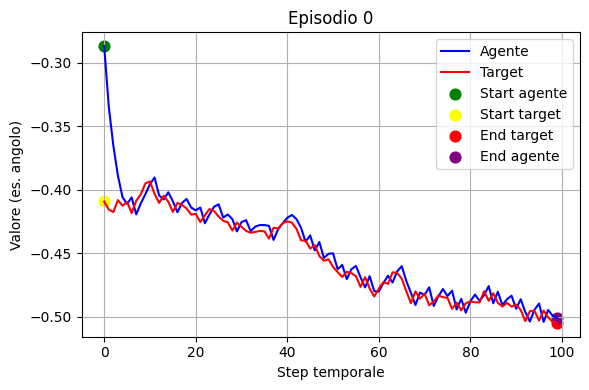

[Episode 1] Steps: 100, Total attached: 85, Mean distance: 0.0162, Success: True
[Episode 2] Steps: 100, Total attached: 81, Mean distance: 0.0152, Success: True
[Episode 3] Steps: 100, Total attached: 81, Mean distance: 0.0136, Success: True
[Episode 4] Steps: 100, Total attached: 90, Mean distance: 0.0153, Success: True
[Episode 5] Steps: 100, Total attached: 91, Mean distance: 0.0160, Success: True
[Episode 6] Steps: 100, Total attached: 97, Mean distance: 0.0147, Success: True
[Episode 7] Steps: 100, Total attached: 82, Mean distance: 0.0141, Success: True
[Episode 8] Steps: 100, Total attached: 87, Mean distance: 0.0170, Success: True
[Episode 9] Steps: 100, Total attached: 87, Mean distance: 0.0168, Success: True
[Episode 10] Steps: 100, Total attached: 95, Mean distance: 0.0158, Success: True
[Episode 11] Steps: 100, Total attached: 84, Mean distance: 0.0188, Success: True
[Episode 12] Steps: 100, Total attached: 91, Mean distance: 0.0181, Success: True
[Episode 13] Steps: 100, 

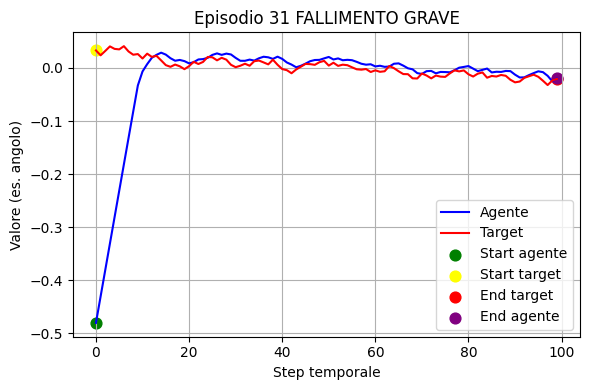

[Episode 31] Steps: 100, Total attached: 68, Mean distance: 0.0195, Success: False
[Episode 32] Steps: 100, Total attached: 92, Mean distance: 0.0191, Success: True
[Episode 33] Steps: 100, Total attached: 85, Mean distance: 0.0189, Success: True
[Episode 34] Steps: 100, Total attached: 84, Mean distance: 0.0198, Success: True
Fail episode 35 with total attached: 61


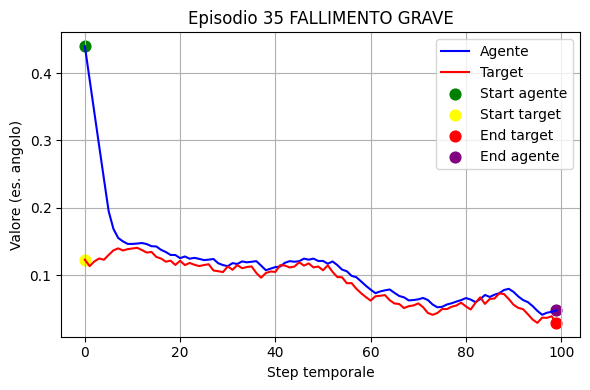

[Episode 35] Steps: 100, Total attached: 61, Mean distance: 0.0198, Success: False
[Episode 36] Steps: 100, Total attached: 84, Mean distance: 0.0197, Success: True
[Episode 37] Steps: 100, Total attached: 82, Mean distance: 0.0194, Success: True
Fail episode 38 with total attached: 60


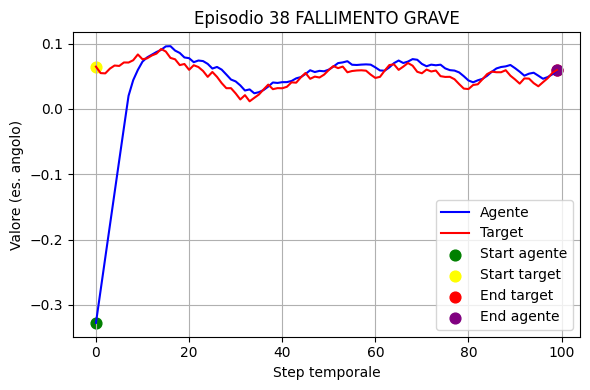

[Episode 38] Steps: 100, Total attached: 60, Mean distance: 0.0195, Success: False
[Episode 39] Steps: 100, Total attached: 93, Mean distance: 0.0192, Success: True
[Episode 40] Steps: 100, Total attached: 89, Mean distance: 0.0193, Success: True
[Episode 41] Steps: 100, Total attached: 83, Mean distance: 0.0193, Success: True
Fail episode 42 with total attached: 66


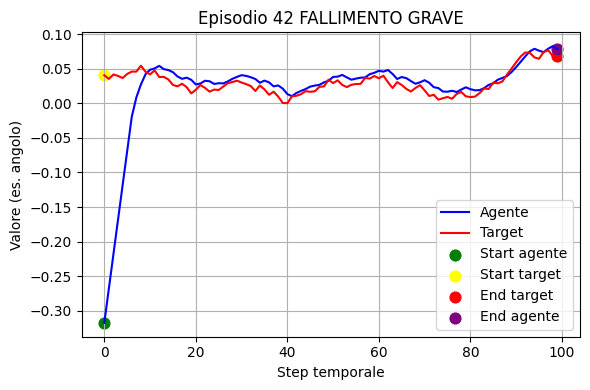

[Episode 42] Steps: 100, Total attached: 66, Mean distance: 0.0193, Success: False
[Episode 43] Steps: 100, Total attached: 93, Mean distance: 0.0192, Success: True
[Episode 44] Steps: 100, Total attached: 91, Mean distance: 0.0189, Success: True
[Episode 45] Steps: 100, Total attached: 90, Mean distance: 0.0191, Success: True
[Episode 46] Steps: 100, Total attached: 82, Mean distance: 0.0199, Success: True
[Episode 47] Steps: 100, Total attached: 84, Mean distance: 0.0207, Success: True
[Episode 48] Steps: 100, Total attached: 93, Mean distance: 0.0205, Success: True
[Episode 49] Steps: 100, Total attached: 99, Mean distance: 0.0201, Success: True
[Episode 50] Steps: 100, Total attached: 89, Mean distance: 0.0198, Success: True
[Episode 51] Steps: 100, Total attached: 89, Mean distance: 0.0200, Success: True
Fail episode 52 with total attached: 65


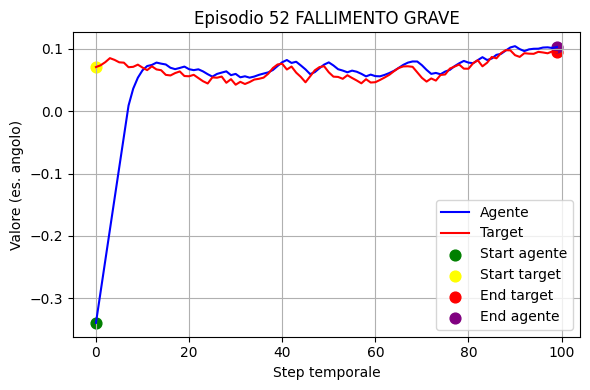

[Episode 52] Steps: 100, Total attached: 65, Mean distance: 0.0201, Success: False
[Episode 53] Steps: 100, Total attached: 100, Mean distance: 0.0198, Success: True
[Episode 54] Steps: 100, Total attached: 96, Mean distance: 0.0196, Success: True
[Episode 55] Steps: 100, Total attached: 80, Mean distance: 0.0195, Success: False
Fail episode 56 with total attached: 63


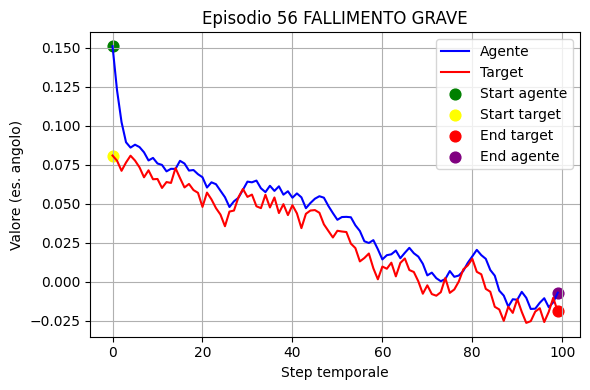

[Episode 56] Steps: 100, Total attached: 63, Mean distance: 0.0193, Success: False
[Episode 57] Steps: 100, Total attached: 97, Mean distance: 0.0190, Success: True
[Episode 58] Steps: 100, Total attached: 89, Mean distance: 0.0192, Success: True
Fail episode 59 with total attached: 54


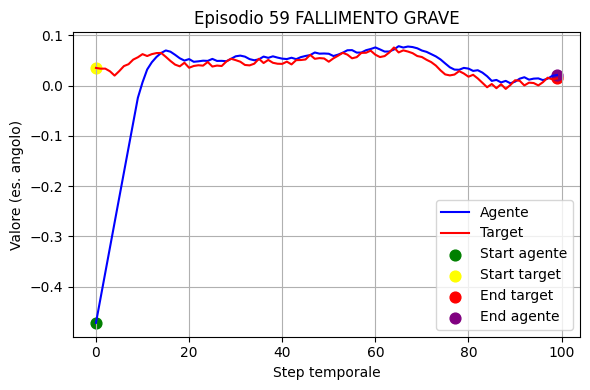

[Episode 59] Steps: 100, Total attached: 54, Mean distance: 0.0194, Success: False
[Episode 60] Steps: 100, Total attached: 84, Mean distance: 0.0193, Success: True
[Episode 61] Steps: 100, Total attached: 78, Mean distance: 0.0192, Success: False
[Episode 62] Steps: 100, Total attached: 90, Mean distance: 0.0189, Success: True
[Episode 63] Steps: 100, Total attached: 89, Mean distance: 0.0188, Success: True
[Episode 64] Steps: 100, Total attached: 94, Mean distance: 0.0188, Success: True
[Episode 65] Steps: 100, Total attached: 87, Mean distance: 0.0189, Success: True
[Episode 66] Steps: 100, Total attached: 77, Mean distance: 0.0190, Success: False
[Episode 67] Steps: 100, Total attached: 80, Mean distance: 0.0190, Success: False
[Episode 68] Steps: 100, Total attached: 90, Mean distance: 0.0190, Success: True
[Episode 69] Steps: 100, Total attached: 82, Mean distance: 0.0199, Success: True
Fail episode 70 with total attached: 58


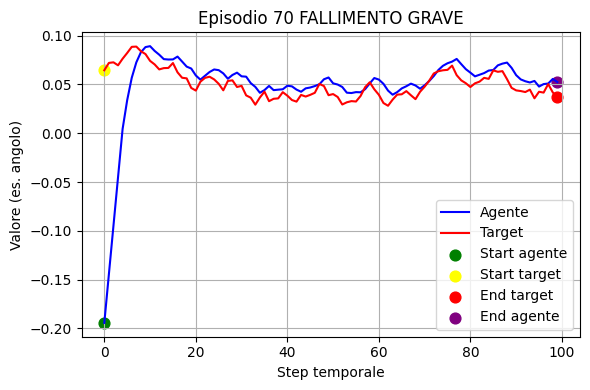

[Episode 70] Steps: 100, Total attached: 58, Mean distance: 0.0199, Success: False
[Episode 71] Steps: 100, Total attached: 97, Mean distance: 0.0196, Success: True
[Episode 72] Steps: 100, Total attached: 91, Mean distance: 0.0196, Success: True
[Episode 73] Steps: 100, Total attached: 94, Mean distance: 0.0195, Success: True
[Episode 74] Steps: 100, Total attached: 78, Mean distance: 0.0198, Success: False
[Episode 75] Steps: 100, Total attached: 92, Mean distance: 0.0196, Success: True
[Episode 76] Steps: 100, Total attached: 86, Mean distance: 0.0200, Success: True
[Episode 77] Steps: 100, Total attached: 89, Mean distance: 0.0199, Success: True
[Episode 78] Steps: 100, Total attached: 74, Mean distance: 0.0199, Success: False
[Episode 79] Steps: 100, Total attached: 91, Mean distance: 0.0197, Success: True
[Episode 80] Steps: 100, Total attached: 90, Mean distance: 0.0195, Success: True
[Episode 81] Steps: 100, Total attached: 91, Mean distance: 0.0195, Success: True
Fail episode 

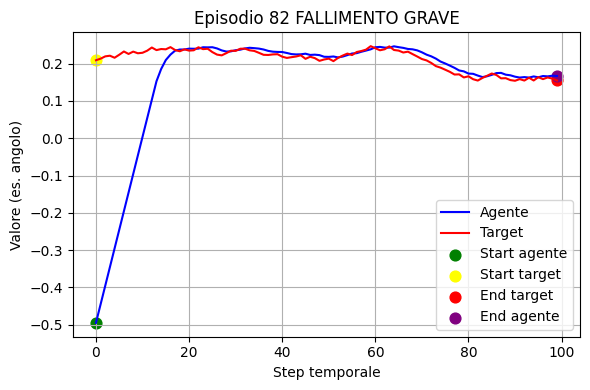

[Episode 82] Steps: 100, Total attached: 67, Mean distance: 0.0199, Success: False
[Episode 83] Steps: 100, Total attached: 92, Mean distance: 0.0198, Success: True
[Episode 84] Steps: 100, Total attached: 99, Mean distance: 0.0196, Success: True
[Episode 85] Steps: 100, Total attached: 94, Mean distance: 0.0195, Success: True
[Episode 86] Steps: 100, Total attached: 85, Mean distance: 0.0195, Success: True
Fail episode 87 with total attached: 63


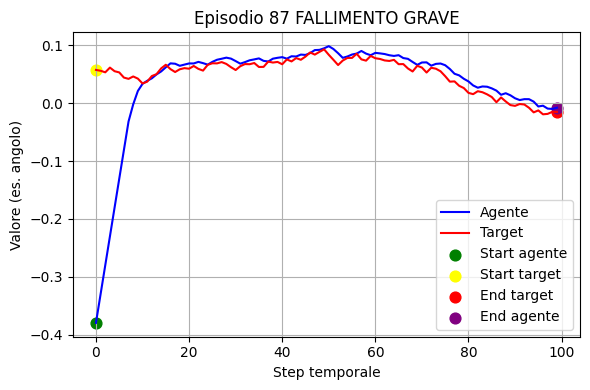

[Episode 87] Steps: 100, Total attached: 63, Mean distance: 0.0196, Success: False
[Episode 88] Steps: 100, Total attached: 91, Mean distance: 0.0196, Success: True
[Episode 89] Steps: 100, Total attached: 83, Mean distance: 0.0195, Success: True
[Episode 90] Steps: 100, Total attached: 96, Mean distance: 0.0193, Success: True
[Episode 91] Steps: 100, Total attached: 91, Mean distance: 0.0192, Success: True
[Episode 92] Steps: 100, Total attached: 84, Mean distance: 0.0194, Success: True
[Episode 93] Steps: 100, Total attached: 92, Mean distance: 0.0193, Success: True
[Episode 94] Steps: 100, Total attached: 84, Mean distance: 0.0193, Success: True
[Episode 95] Steps: 100, Total attached: 84, Mean distance: 0.0197, Success: True
[Episode 96] Steps: 100, Total attached: 84, Mean distance: 0.0201, Success: True
[Episode 97] Steps: 100, Total attached: 79, Mean distance: 0.0204, Success: False
[Episode 98] Steps: 100, Total attached: 91, Mean distance: 0.0203, Success: True
[Episode 99] S

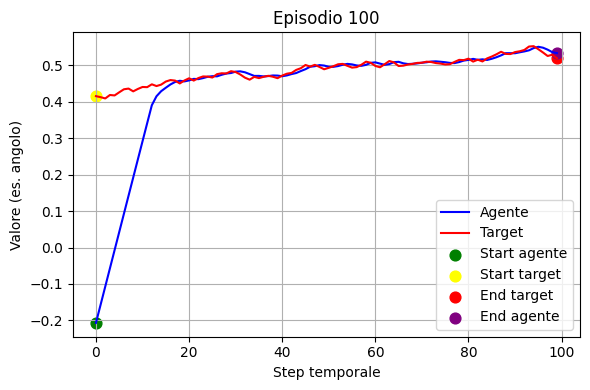

[Episode 101] Steps: 100, Total attached: 95, Mean distance: 0.0203, Success: True
[Episode 102] Steps: 100, Total attached: 79, Mean distance: 0.0202, Success: False
[Episode 103] Steps: 100, Total attached: 95, Mean distance: 0.0201, Success: True
[Episode 104] Steps: 100, Total attached: 80, Mean distance: 0.0207, Success: False
[Episode 105] Steps: 100, Total attached: 86, Mean distance: 0.0205, Success: True
[Episode 106] Steps: 100, Total attached: 95, Mean distance: 0.0204, Success: True
[Episode 107] Steps: 100, Total attached: 80, Mean distance: 0.0211, Success: False
[Episode 108] Steps: 100, Total attached: 82, Mean distance: 0.0210, Success: True
[Episode 109] Steps: 100, Total attached: 90, Mean distance: 0.0210, Success: True
[Episode 110] Steps: 100, Total attached: 82, Mean distance: 0.0209, Success: True
[Episode 111] Steps: 100, Total attached: 92, Mean distance: 0.0208, Success: True
[Episode 112] Steps: 100, Total attached: 85, Mean distance: 0.0210, Success: True
[

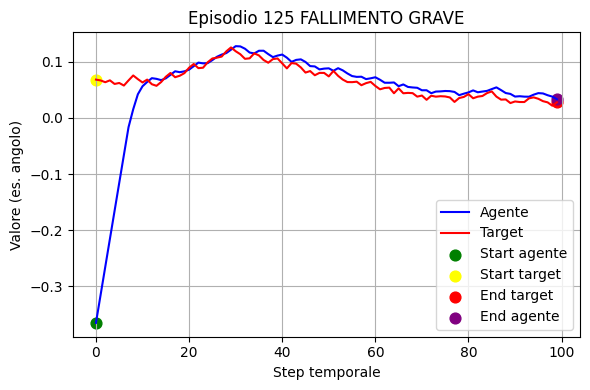

[Episode 125] Steps: 100, Total attached: 66, Mean distance: 0.0218, Success: False
[Episode 126] Steps: 100, Total attached: 81, Mean distance: 0.0220, Success: True
[Episode 127] Steps: 100, Total attached: 75, Mean distance: 0.0219, Success: False
[Episode 128] Steps: 100, Total attached: 88, Mean distance: 0.0218, Success: True
[Episode 129] Steps: 100, Total attached: 89, Mean distance: 0.0218, Success: True
Fail episode 130 with total attached: 64


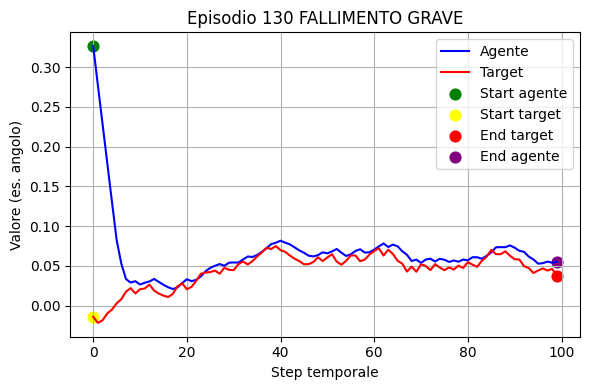

[Episode 130] Steps: 100, Total attached: 64, Mean distance: 0.0218, Success: False
[Episode 131] Steps: 100, Total attached: 86, Mean distance: 0.0219, Success: True
[Episode 132] Steps: 100, Total attached: 84, Mean distance: 0.0220, Success: True
[Episode 133] Steps: 100, Total attached: 89, Mean distance: 0.0219, Success: True
[Episode 134] Steps: 100, Total attached: 85, Mean distance: 0.0222, Success: True
[Episode 135] Steps: 100, Total attached: 77, Mean distance: 0.0222, Success: False
[Episode 136] Steps: 100, Total attached: 84, Mean distance: 0.0224, Success: True
[Episode 137] Steps: 100, Total attached: 89, Mean distance: 0.0224, Success: True
[Episode 138] Steps: 100, Total attached: 95, Mean distance: 0.0222, Success: True
[Episode 139] Steps: 100, Total attached: 91, Mean distance: 0.0222, Success: True
[Episode 140] Steps: 100, Total attached: 91, Mean distance: 0.0221, Success: True
[Episode 141] Steps: 100, Total attached: 83, Mean distance: 0.0224, Success: True
[E

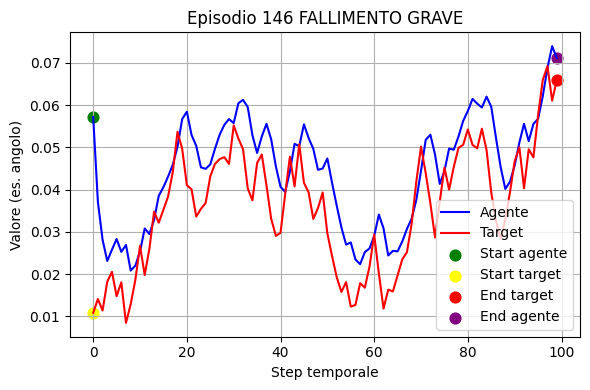

[Episode 146] Steps: 100, Total attached: 69, Mean distance: 0.0226, Success: False
[Episode 147] Steps: 100, Total attached: 79, Mean distance: 0.0225, Success: False
[Episode 148] Steps: 100, Total attached: 77, Mean distance: 0.0224, Success: False
[Episode 149] Steps: 100, Total attached: 89, Mean distance: 0.0224, Success: True
[Episode 150] Steps: 100, Total attached: 74, Mean distance: 0.0228, Success: False
[Episode 151] Steps: 100, Total attached: 80, Mean distance: 0.0227, Success: False
[Episode 152] Steps: 100, Total attached: 85, Mean distance: 0.0227, Success: True
[Episode 153] Steps: 100, Total attached: 99, Mean distance: 0.0226, Success: True
[Episode 154] Steps: 100, Total attached: 91, Mean distance: 0.0225, Success: True
[Episode 155] Steps: 100, Total attached: 96, Mean distance: 0.0224, Success: True
[Episode 156] Steps: 100, Total attached: 95, Mean distance: 0.0223, Success: True
[Episode 157] Steps: 100, Total attached: 96, Mean distance: 0.0222, Success: True

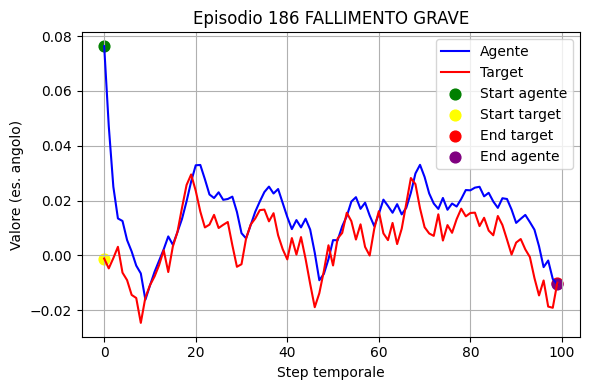

[Episode 186] Steps: 100, Total attached: 68, Mean distance: 0.0222, Success: False
[Episode 187] Steps: 100, Total attached: 89, Mean distance: 0.0222, Success: True
[Episode 188] Steps: 100, Total attached: 89, Mean distance: 0.0221, Success: True
[Episode 189] Steps: 100, Total attached: 77, Mean distance: 0.0220, Success: False
Fail episode 190 with total attached: 65


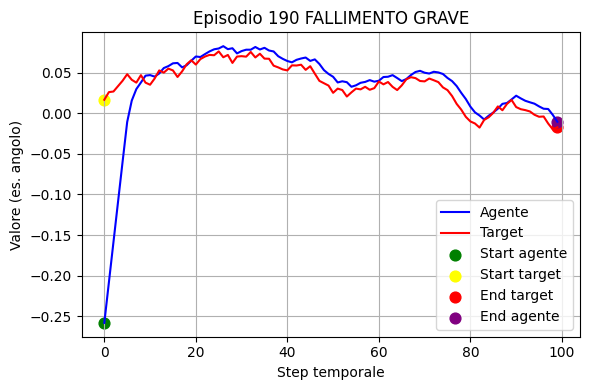

[Episode 190] Steps: 100, Total attached: 65, Mean distance: 0.0220, Success: False
[Episode 191] Steps: 100, Total attached: 93, Mean distance: 0.0219, Success: True
[Episode 192] Steps: 100, Total attached: 97, Mean distance: 0.0218, Success: True
[Episode 193] Steps: 100, Total attached: 98, Mean distance: 0.0217, Success: True
[Episode 194] Steps: 100, Total attached: 86, Mean distance: 0.0217, Success: True
[Episode 195] Steps: 100, Total attached: 83, Mean distance: 0.0216, Success: True
[Episode 196] Steps: 100, Total attached: 91, Mean distance: 0.0216, Success: True
[Episode 197] Steps: 100, Total attached: 95, Mean distance: 0.0216, Success: True
[Episode 198] Steps: 100, Total attached: 83, Mean distance: 0.0215, Success: True
[Episode 199] Steps: 100, Total attached: 71, Mean distance: 0.0216, Success: False
[Episode 200] Steps: 100, Total attached: 87, Mean distance: 0.0216, Success: True


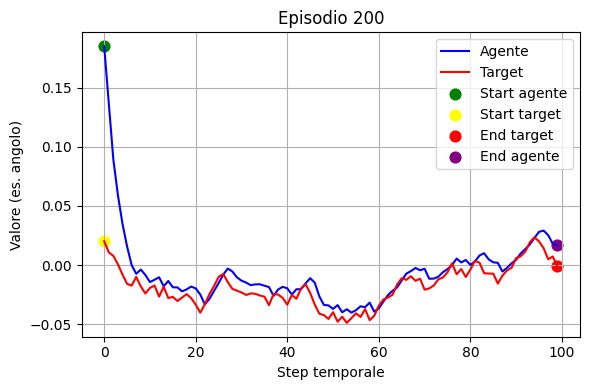

[Episode 201] Steps: 100, Total attached: 93, Mean distance: 0.0215, Success: True
[Episode 202] Steps: 100, Total attached: 96, Mean distance: 0.0215, Success: True
[Episode 203] Steps: 100, Total attached: 98, Mean distance: 0.0214, Success: True
[Episode 204] Steps: 100, Total attached: 82, Mean distance: 0.0213, Success: True
[Episode 205] Steps: 100, Total attached: 89, Mean distance: 0.0213, Success: True
[Episode 206] Steps: 100, Total attached: 79, Mean distance: 0.0212, Success: False
[Episode 207] Steps: 100, Total attached: 90, Mean distance: 0.0212, Success: True
[Episode 208] Steps: 100, Total attached: 87, Mean distance: 0.0212, Success: True
[Episode 209] Steps: 100, Total attached: 93, Mean distance: 0.0212, Success: True
[Episode 210] Steps: 100, Total attached: 81, Mean distance: 0.0212, Success: True
[Episode 211] Steps: 100, Total attached: 85, Mean distance: 0.0212, Success: True
[Episode 212] Steps: 100, Total attached: 80, Mean distance: 0.0212, Success: False
[E

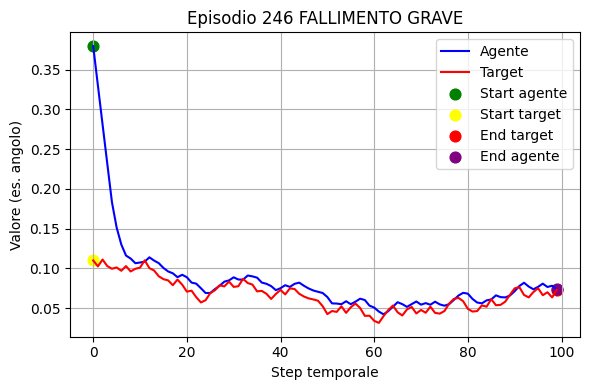

[Episode 246] Steps: 100, Total attached: 64, Mean distance: 0.0210, Success: False
[Episode 247] Steps: 100, Total attached: 83, Mean distance: 0.0211, Success: True
[Episode 248] Steps: 100, Total attached: 85, Mean distance: 0.0211, Success: True
[Episode 249] Steps: 100, Total attached: 94, Mean distance: 0.0210, Success: True
[Episode 250] Steps: 100, Total attached: 86, Mean distance: 0.0210, Success: True
[Episode 251] Steps: 100, Total attached: 97, Mean distance: 0.0209, Success: True
[Episode 252] Steps: 100, Total attached: 80, Mean distance: 0.0210, Success: False
[Episode 253] Steps: 100, Total attached: 83, Mean distance: 0.0210, Success: True
[Episode 254] Steps: 100, Total attached: 86, Mean distance: 0.0211, Success: True
[Episode 255] Steps: 100, Total attached: 84, Mean distance: 0.0211, Success: True
[Episode 256] Steps: 100, Total attached: 97, Mean distance: 0.0210, Success: True
[Episode 257] Steps: 100, Total attached: 76, Mean distance: 0.0210, Success: False
[

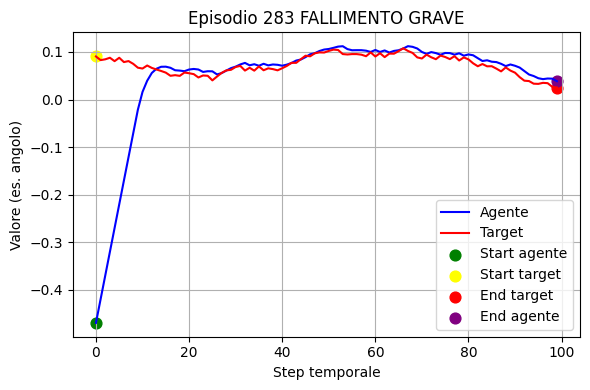

[Episode 283] Steps: 100, Total attached: 66, Mean distance: 0.0214, Success: False
Fail episode 284 with total attached: 61


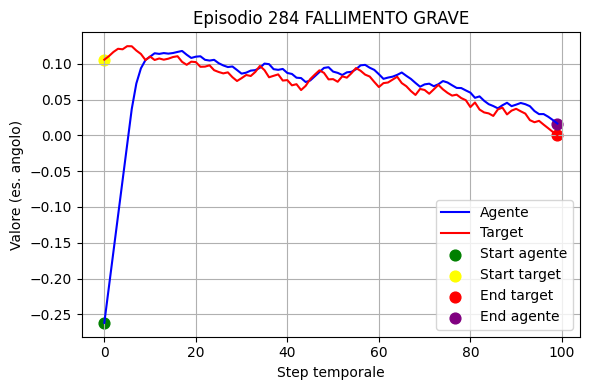

[Episode 284] Steps: 100, Total attached: 61, Mean distance: 0.0214, Success: False
[Episode 285] Steps: 100, Total attached: 83, Mean distance: 0.0214, Success: True
[Episode 286] Steps: 100, Total attached: 90, Mean distance: 0.0214, Success: True
[Episode 287] Steps: 100, Total attached: 84, Mean distance: 0.0215, Success: True
[Episode 288] Steps: 100, Total attached: 84, Mean distance: 0.0216, Success: True
[Episode 289] Steps: 100, Total attached: 100, Mean distance: 0.0215, Success: True
[Episode 290] Steps: 100, Total attached: 80, Mean distance: 0.0216, Success: False
[Episode 291] Steps: 100, Total attached: 76, Mean distance: 0.0216, Success: False
[Episode 292] Steps: 100, Total attached: 85, Mean distance: 0.0215, Success: True
[Episode 293] Steps: 100, Total attached: 93, Mean distance: 0.0215, Success: True
[Episode 294] Steps: 100, Total attached: 90, Mean distance: 0.0215, Success: True
[Episode 295] Steps: 100, Total attached: 81, Mean distance: 0.0215, Success: True


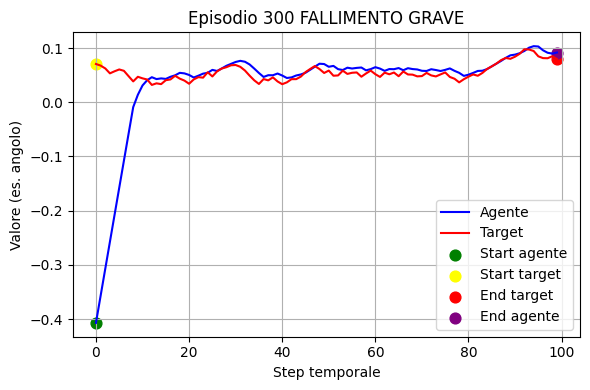

[Episode 300] Steps: 100, Total attached: 68, Mean distance: 0.0214, Success: False


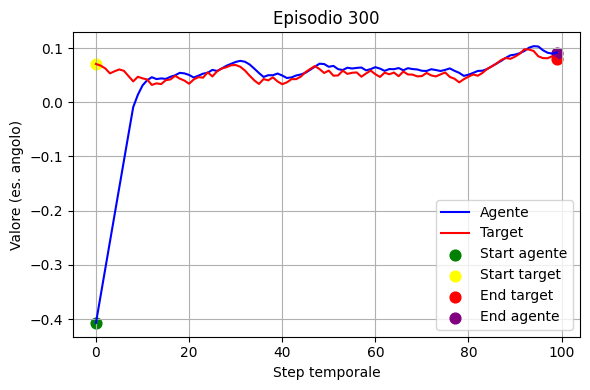

[Episode 301] Steps: 100, Total attached: 88, Mean distance: 0.0214, Success: True
[Episode 302] Steps: 100, Total attached: 100, Mean distance: 0.0214, Success: True
[Episode 303] Steps: 100, Total attached: 96, Mean distance: 0.0213, Success: True
[Episode 304] Steps: 100, Total attached: 87, Mean distance: 0.0213, Success: True
[Episode 305] Steps: 100, Total attached: 96, Mean distance: 0.0212, Success: True
Fail episode 306 with total attached: 62


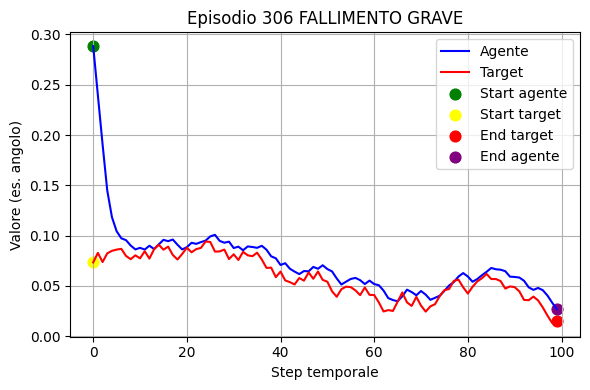

[Episode 306] Steps: 100, Total attached: 62, Mean distance: 0.0212, Success: False
[Episode 307] Steps: 100, Total attached: 79, Mean distance: 0.0212, Success: False
[Episode 308] Steps: 100, Total attached: 93, Mean distance: 0.0211, Success: True
[Episode 309] Steps: 100, Total attached: 85, Mean distance: 0.0211, Success: True
[Episode 310] Steps: 100, Total attached: 83, Mean distance: 0.0212, Success: True
[Episode 311] Steps: 100, Total attached: 79, Mean distance: 0.0212, Success: False
[Episode 312] Steps: 100, Total attached: 79, Mean distance: 0.0212, Success: False
[Episode 313] Steps: 100, Total attached: 77, Mean distance: 0.0212, Success: False
[Episode 314] Steps: 100, Total attached: 79, Mean distance: 0.0213, Success: False
[Episode 315] Steps: 100, Total attached: 88, Mean distance: 0.0212, Success: True
[Episode 316] Steps: 100, Total attached: 93, Mean distance: 0.0212, Success: True
[Episode 317] Steps: 100, Total attached: 77, Mean distance: 0.0214, Success: Fal

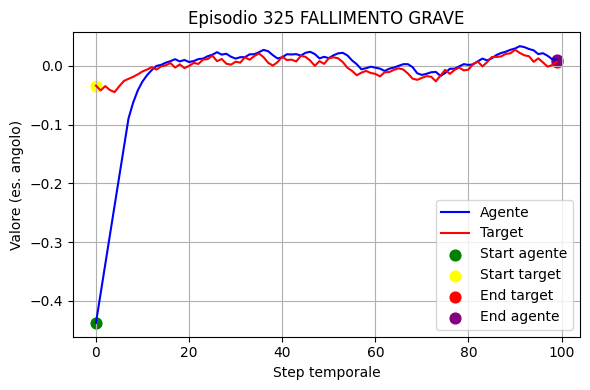

[Episode 325] Steps: 100, Total attached: 68, Mean distance: 0.0216, Success: False
[Episode 326] Steps: 100, Total attached: 88, Mean distance: 0.0216, Success: True
[Episode 327] Steps: 100, Total attached: 84, Mean distance: 0.0216, Success: True
[Episode 328] Steps: 100, Total attached: 76, Mean distance: 0.0216, Success: False
[Episode 329] Steps: 100, Total attached: 94, Mean distance: 0.0216, Success: True
[Episode 330] Steps: 100, Total attached: 87, Mean distance: 0.0216, Success: True
[Episode 331] Steps: 100, Total attached: 76, Mean distance: 0.0216, Success: False
[Episode 332] Steps: 100, Total attached: 95, Mean distance: 0.0215, Success: True
[Episode 333] Steps: 100, Total attached: 83, Mean distance: 0.0216, Success: True
[Episode 334] Steps: 100, Total attached: 92, Mean distance: 0.0215, Success: True
[Episode 335] Steps: 100, Total attached: 77, Mean distance: 0.0215, Success: False
[Episode 336] Steps: 100, Total attached: 94, Mean distance: 0.0214, Success: True


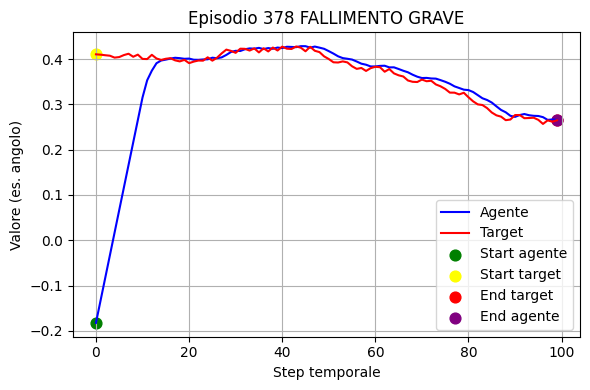

[Episode 378] Steps: 100, Total attached: 67, Mean distance: 0.0222, Success: False
[Episode 379] Steps: 100, Total attached: 86, Mean distance: 0.0222, Success: True
Fail episode 380 with total attached: 65


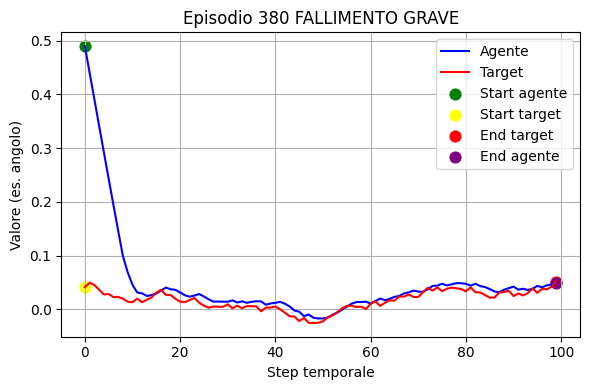

[Episode 380] Steps: 100, Total attached: 65, Mean distance: 0.0222, Success: False
[Episode 381] Steps: 100, Total attached: 85, Mean distance: 0.0222, Success: True
[Episode 382] Steps: 100, Total attached: 96, Mean distance: 0.0222, Success: True
[Episode 383] Steps: 100, Total attached: 86, Mean distance: 0.0222, Success: True
[Episode 384] Steps: 100, Total attached: 88, Mean distance: 0.0223, Success: True
[Episode 385] Steps: 100, Total attached: 87, Mean distance: 0.0222, Success: True
[Episode 386] Steps: 100, Total attached: 80, Mean distance: 0.0224, Success: False
[Episode 387] Steps: 100, Total attached: 77, Mean distance: 0.0224, Success: False
[Episode 388] Steps: 100, Total attached: 86, Mean distance: 0.0223, Success: True
[Episode 389] Steps: 100, Total attached: 74, Mean distance: 0.0223, Success: False
[Episode 390] Steps: 100, Total attached: 90, Mean distance: 0.0223, Success: True
[Episode 391] Steps: 100, Total attached: 73, Mean distance: 0.0224, Success: False

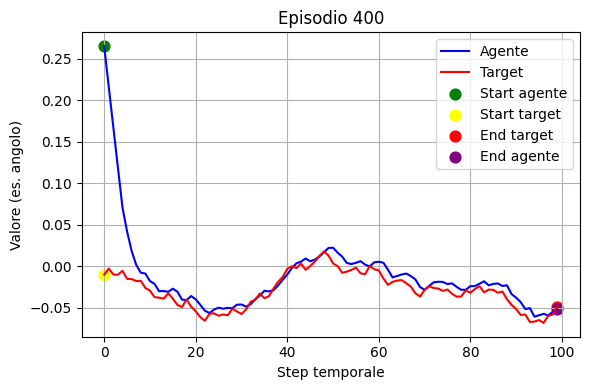

[Episode 401] Steps: 100, Total attached: 93, Mean distance: 0.0226, Success: True
[Episode 402] Steps: 100, Total attached: 83, Mean distance: 0.0227, Success: True
[Episode 403] Steps: 100, Total attached: 89, Mean distance: 0.0226, Success: True
[Episode 404] Steps: 100, Total attached: 100, Mean distance: 0.0226, Success: True
[Episode 405] Steps: 100, Total attached: 89, Mean distance: 0.0226, Success: True
[Episode 406] Steps: 100, Total attached: 86, Mean distance: 0.0225, Success: True
[Episode 407] Steps: 100, Total attached: 78, Mean distance: 0.0225, Success: False
[Episode 408] Steps: 100, Total attached: 87, Mean distance: 0.0225, Success: True
[Episode 409] Steps: 100, Total attached: 77, Mean distance: 0.0225, Success: False
Fail episode 410 with total attached: 63


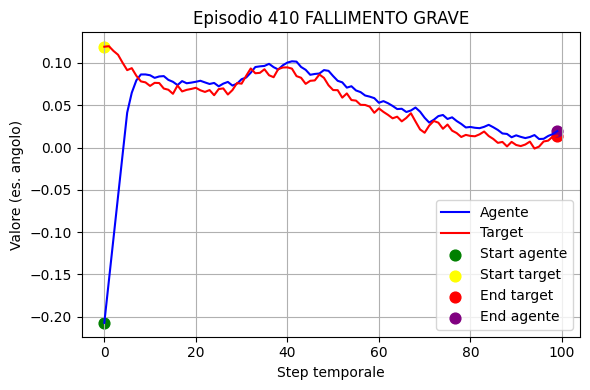

[Episode 410] Steps: 100, Total attached: 63, Mean distance: 0.0225, Success: False
[Episode 411] Steps: 100, Total attached: 83, Mean distance: 0.0226, Success: True
[Episode 412] Steps: 100, Total attached: 98, Mean distance: 0.0225, Success: True
[Episode 413] Steps: 100, Total attached: 84, Mean distance: 0.0225, Success: True
[Episode 414] Steps: 100, Total attached: 83, Mean distance: 0.0225, Success: True
[Episode 415] Steps: 100, Total attached: 81, Mean distance: 0.0224, Success: True
[Episode 416] Steps: 100, Total attached: 86, Mean distance: 0.0224, Success: True
[Episode 417] Steps: 100, Total attached: 94, Mean distance: 0.0223, Success: True
[Episode 418] Steps: 100, Total attached: 81, Mean distance: 0.0223, Success: True
[Episode 419] Steps: 100, Total attached: 89, Mean distance: 0.0223, Success: True
[Episode 420] Steps: 100, Total attached: 77, Mean distance: 0.0223, Success: False
[Episode 421] Steps: 100, Total attached: 81, Mean distance: 0.0223, Success: True
[E

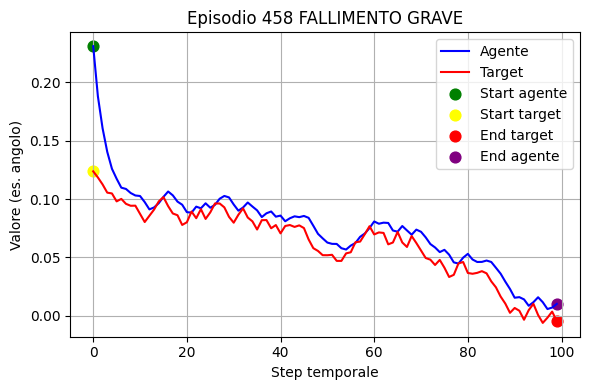

[Episode 458] Steps: 100, Total attached: 61, Mean distance: 0.0223, Success: False
[Episode 459] Steps: 100, Total attached: 99, Mean distance: 0.0222, Success: True
[Episode 460] Steps: 100, Total attached: 83, Mean distance: 0.0222, Success: True
[Episode 461] Steps: 100, Total attached: 82, Mean distance: 0.0222, Success: True
[Episode 462] Steps: 100, Total attached: 82, Mean distance: 0.0223, Success: True
[Episode 463] Steps: 100, Total attached: 96, Mean distance: 0.0223, Success: True
[Episode 464] Steps: 100, Total attached: 90, Mean distance: 0.0223, Success: True
[Episode 465] Steps: 100, Total attached: 88, Mean distance: 0.0222, Success: True
[Episode 466] Steps: 100, Total attached: 85, Mean distance: 0.0222, Success: True
[Episode 467] Steps: 100, Total attached: 86, Mean distance: 0.0223, Success: True
[Episode 468] Steps: 100, Total attached: 80, Mean distance: 0.0224, Success: False
[Episode 469] Steps: 100, Total attached: 93, Mean distance: 0.0224, Success: True
[E

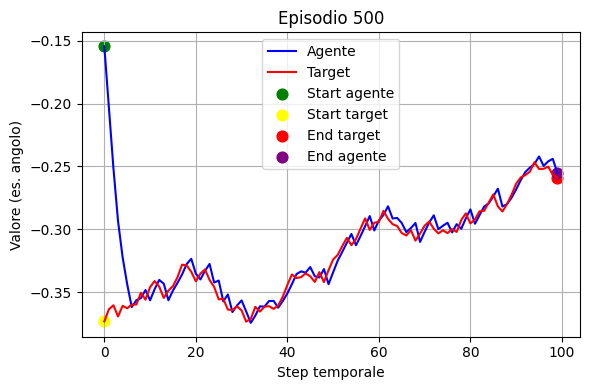

[Episode 501] Steps: 100, Total attached: 85, Mean distance: 0.0223, Success: True
[Episode 502] Steps: 100, Total attached: 81, Mean distance: 0.0224, Success: True
[Episode 503] Steps: 100, Total attached: 96, Mean distance: 0.0224, Success: True
[Episode 504] Steps: 100, Total attached: 88, Mean distance: 0.0224, Success: True
[Episode 505] Steps: 100, Total attached: 92, Mean distance: 0.0224, Success: True
[Episode 506] Steps: 100, Total attached: 85, Mean distance: 0.0224, Success: True
[Episode 507] Steps: 100, Total attached: 83, Mean distance: 0.0225, Success: True
[Episode 508] Steps: 100, Total attached: 81, Mean distance: 0.0225, Success: True
[Episode 509] Steps: 100, Total attached: 78, Mean distance: 0.0225, Success: False
[Episode 510] Steps: 100, Total attached: 88, Mean distance: 0.0225, Success: True
[Episode 511] Steps: 100, Total attached: 85, Mean distance: 0.0224, Success: True
[Episode 512] Steps: 100, Total attached: 80, Mean distance: 0.0225, Success: False
[E

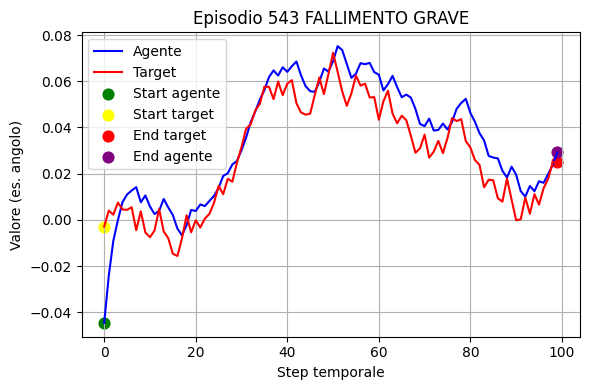

[Episode 543] Steps: 100, Total attached: 68, Mean distance: 0.0225, Success: False
[Episode 544] Steps: 100, Total attached: 90, Mean distance: 0.0225, Success: True
[Episode 545] Steps: 100, Total attached: 95, Mean distance: 0.0225, Success: True
Fail episode 546 with total attached: 61


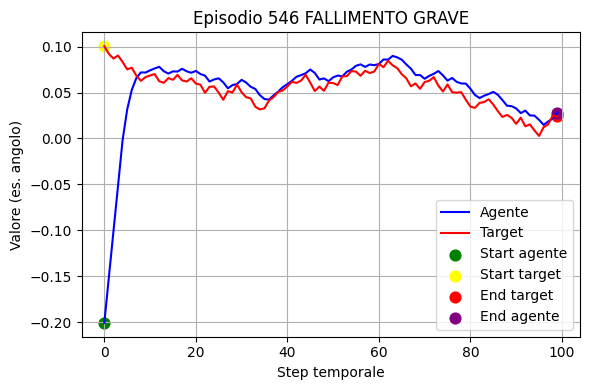

[Episode 546] Steps: 100, Total attached: 61, Mean distance: 0.0225, Success: False
[Episode 547] Steps: 100, Total attached: 74, Mean distance: 0.0225, Success: False
[Episode 548] Steps: 100, Total attached: 89, Mean distance: 0.0225, Success: True
[Episode 549] Steps: 100, Total attached: 87, Mean distance: 0.0226, Success: True
[Episode 550] Steps: 100, Total attached: 82, Mean distance: 0.0225, Success: True
[Episode 551] Steps: 100, Total attached: 80, Mean distance: 0.0225, Success: False
[Episode 552] Steps: 100, Total attached: 94, Mean distance: 0.0225, Success: True
[Episode 553] Steps: 100, Total attached: 84, Mean distance: 0.0225, Success: True
[Episode 554] Steps: 100, Total attached: 84, Mean distance: 0.0225, Success: True
Fail episode 555 with total attached: 61


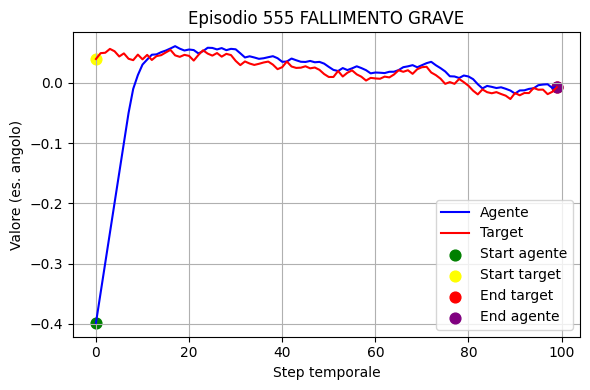

[Episode 555] Steps: 100, Total attached: 61, Mean distance: 0.0225, Success: False
[Episode 556] Steps: 100, Total attached: 90, Mean distance: 0.0225, Success: True
Fail episode 557 with total attached: 65


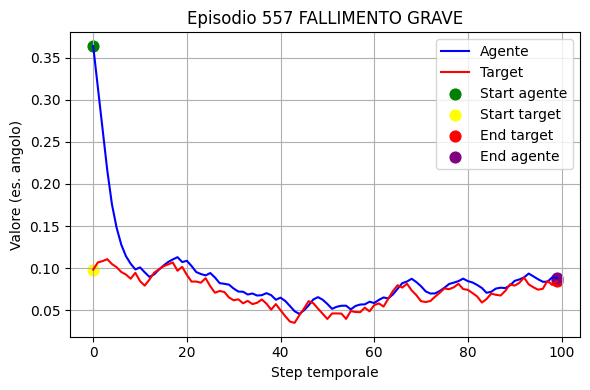

[Episode 557] Steps: 100, Total attached: 65, Mean distance: 0.0225, Success: False
[Episode 558] Steps: 100, Total attached: 82, Mean distance: 0.0225, Success: True
[Episode 559] Steps: 100, Total attached: 91, Mean distance: 0.0225, Success: True
[Episode 560] Steps: 100, Total attached: 86, Mean distance: 0.0225, Success: True
[Episode 561] Steps: 100, Total attached: 96, Mean distance: 0.0225, Success: True
[Episode 562] Steps: 100, Total attached: 89, Mean distance: 0.0225, Success: True
[Episode 563] Steps: 100, Total attached: 84, Mean distance: 0.0225, Success: True
[Episode 564] Steps: 100, Total attached: 88, Mean distance: 0.0226, Success: True
[Episode 565] Steps: 100, Total attached: 87, Mean distance: 0.0225, Success: True
[Episode 566] Steps: 100, Total attached: 93, Mean distance: 0.0225, Success: True
[Episode 567] Steps: 100, Total attached: 87, Mean distance: 0.0225, Success: True
[Episode 568] Steps: 100, Total attached: 86, Mean distance: 0.0225, Success: True
[Ep

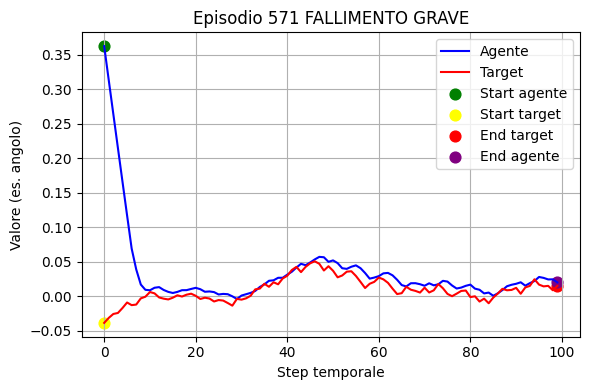

[Episode 571] Steps: 100, Total attached: 69, Mean distance: 0.0225, Success: False
[Episode 572] Steps: 100, Total attached: 82, Mean distance: 0.0225, Success: True
[Episode 573] Steps: 100, Total attached: 87, Mean distance: 0.0225, Success: True
[Episode 574] Steps: 100, Total attached: 91, Mean distance: 0.0225, Success: True
[Episode 575] Steps: 100, Total attached: 86, Mean distance: 0.0225, Success: True
[Episode 576] Steps: 100, Total attached: 98, Mean distance: 0.0225, Success: True
[Episode 577] Steps: 100, Total attached: 74, Mean distance: 0.0225, Success: False
[Episode 578] Steps: 100, Total attached: 96, Mean distance: 0.0225, Success: True
[Episode 579] Steps: 100, Total attached: 84, Mean distance: 0.0225, Success: True
[Episode 580] Steps: 100, Total attached: 94, Mean distance: 0.0225, Success: True
[Episode 581] Steps: 100, Total attached: 94, Mean distance: 0.0225, Success: True
[Episode 582] Steps: 100, Total attached: 100, Mean distance: 0.0225, Success: True
[

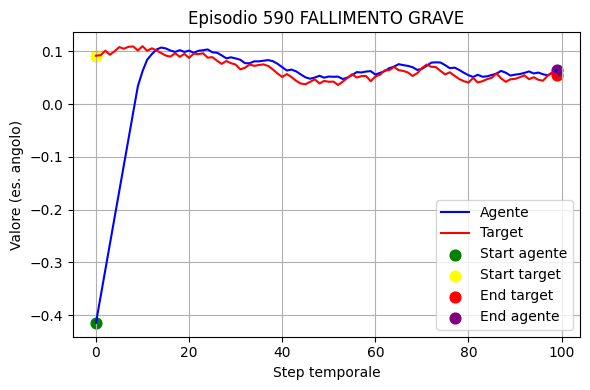

[Episode 590] Steps: 100, Total attached: 61, Mean distance: 0.0224, Success: False
[Episode 591] Steps: 100, Total attached: 81, Mean distance: 0.0225, Success: True
[Episode 592] Steps: 100, Total attached: 89, Mean distance: 0.0225, Success: True
[Episode 593] Steps: 100, Total attached: 96, Mean distance: 0.0225, Success: True
[Episode 594] Steps: 100, Total attached: 83, Mean distance: 0.0225, Success: True
[Episode 595] Steps: 100, Total attached: 89, Mean distance: 0.0225, Success: True
[Episode 596] Steps: 100, Total attached: 86, Mean distance: 0.0225, Success: True
[Episode 597] Steps: 100, Total attached: 73, Mean distance: 0.0225, Success: False
[Episode 598] Steps: 100, Total attached: 100, Mean distance: 0.0225, Success: True
[Episode 599] Steps: 100, Total attached: 82, Mean distance: 0.0225, Success: True
[Episode 600] Steps: 100, Total attached: 75, Mean distance: 0.0225, Success: False


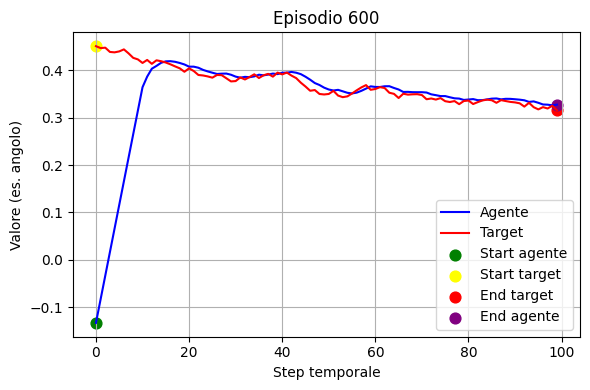

[Episode 601] Steps: 100, Total attached: 94, Mean distance: 0.0225, Success: True
[Episode 602] Steps: 100, Total attached: 73, Mean distance: 0.0224, Success: False
[Episode 603] Steps: 100, Total attached: 97, Mean distance: 0.0224, Success: True
[Episode 604] Steps: 100, Total attached: 85, Mean distance: 0.0225, Success: True
[Episode 605] Steps: 100, Total attached: 87, Mean distance: 0.0224, Success: True
[Episode 606] Steps: 100, Total attached: 84, Mean distance: 0.0224, Success: True
[Episode 607] Steps: 100, Total attached: 86, Mean distance: 0.0225, Success: True
[Episode 608] Steps: 100, Total attached: 95, Mean distance: 0.0224, Success: True
[Episode 609] Steps: 100, Total attached: 94, Mean distance: 0.0224, Success: True
[Episode 610] Steps: 100, Total attached: 75, Mean distance: 0.0224, Success: False
[Episode 611] Steps: 100, Total attached: 92, Mean distance: 0.0224, Success: True
Fail episode 612 with total attached: 66


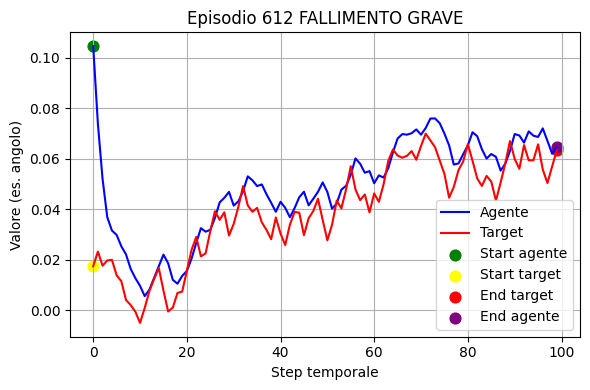

[Episode 612] Steps: 100, Total attached: 66, Mean distance: 0.0224, Success: False
[Episode 613] Steps: 100, Total attached: 86, Mean distance: 0.0224, Success: True
[Episode 614] Steps: 100, Total attached: 92, Mean distance: 0.0224, Success: True
[Episode 615] Steps: 100, Total attached: 81, Mean distance: 0.0224, Success: True
[Episode 616] Steps: 100, Total attached: 83, Mean distance: 0.0224, Success: True
[Episode 617] Steps: 100, Total attached: 87, Mean distance: 0.0224, Success: True
[Episode 618] Steps: 100, Total attached: 78, Mean distance: 0.0225, Success: False
[Episode 619] Steps: 100, Total attached: 71, Mean distance: 0.0225, Success: False
[Episode 620] Steps: 100, Total attached: 76, Mean distance: 0.0225, Success: False
[Episode 621] Steps: 100, Total attached: 83, Mean distance: 0.0225, Success: True
[Episode 622] Steps: 100, Total attached: 94, Mean distance: 0.0225, Success: True
[Episode 623] Steps: 100, Total attached: 89, Mean distance: 0.0225, Success: True


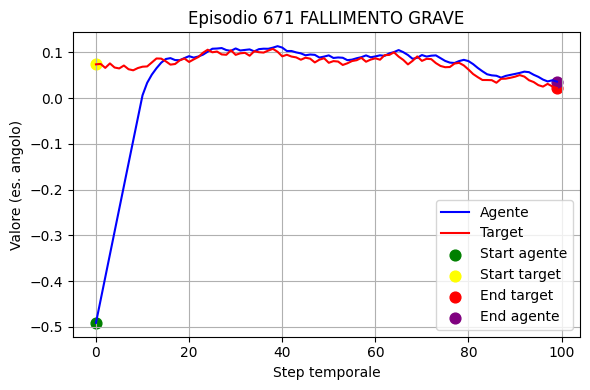

[Episode 671] Steps: 100, Total attached: 66, Mean distance: 0.0222, Success: False
[Episode 672] Steps: 100, Total attached: 84, Mean distance: 0.0222, Success: True
[Episode 673] Steps: 100, Total attached: 98, Mean distance: 0.0222, Success: True
[Episode 674] Steps: 100, Total attached: 83, Mean distance: 0.0221, Success: True
[Episode 675] Steps: 100, Total attached: 79, Mean distance: 0.0221, Success: False
[Episode 676] Steps: 100, Total attached: 80, Mean distance: 0.0221, Success: False
[Episode 677] Steps: 100, Total attached: 89, Mean distance: 0.0221, Success: True
[Episode 678] Steps: 100, Total attached: 80, Mean distance: 0.0221, Success: False
[Episode 679] Steps: 100, Total attached: 82, Mean distance: 0.0221, Success: True
[Episode 680] Steps: 100, Total attached: 87, Mean distance: 0.0221, Success: True
[Episode 681] Steps: 100, Total attached: 86, Mean distance: 0.0221, Success: True
[Episode 682] Steps: 100, Total attached: 85, Mean distance: 0.0221, Success: True


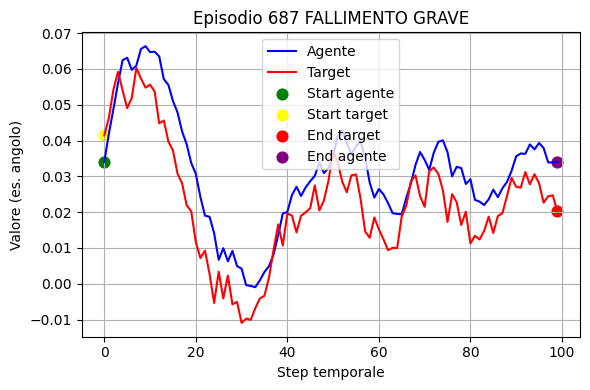

[Episode 687] Steps: 100, Total attached: 67, Mean distance: 0.0221, Success: False
[Episode 688] Steps: 100, Total attached: 95, Mean distance: 0.0221, Success: True
[Episode 689] Steps: 100, Total attached: 97, Mean distance: 0.0220, Success: True
[Episode 690] Steps: 100, Total attached: 100, Mean distance: 0.0220, Success: True
[Episode 691] Steps: 100, Total attached: 88, Mean distance: 0.0220, Success: True
[Episode 692] Steps: 100, Total attached: 75, Mean distance: 0.0221, Success: False
[Episode 693] Steps: 100, Total attached: 93, Mean distance: 0.0221, Success: True
[Episode 694] Steps: 100, Total attached: 88, Mean distance: 0.0220, Success: True
[Episode 695] Steps: 100, Total attached: 89, Mean distance: 0.0220, Success: True
[Episode 696] Steps: 100, Total attached: 71, Mean distance: 0.0220, Success: False
[Episode 697] Steps: 100, Total attached: 88, Mean distance: 0.0220, Success: True
[Episode 698] Steps: 100, Total attached: 91, Mean distance: 0.0220, Success: True


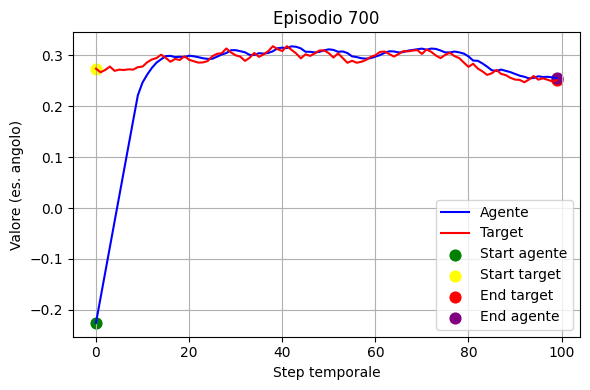

Fail episode 701 with total attached: 64


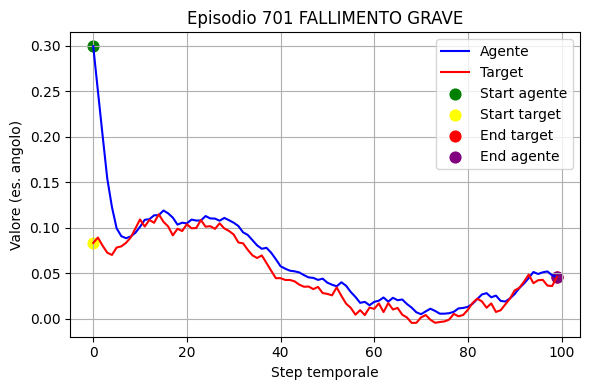

[Episode 701] Steps: 100, Total attached: 64, Mean distance: 0.0220, Success: False
[Episode 702] Steps: 100, Total attached: 88, Mean distance: 0.0220, Success: True
Fail episode 703 with total attached: 65


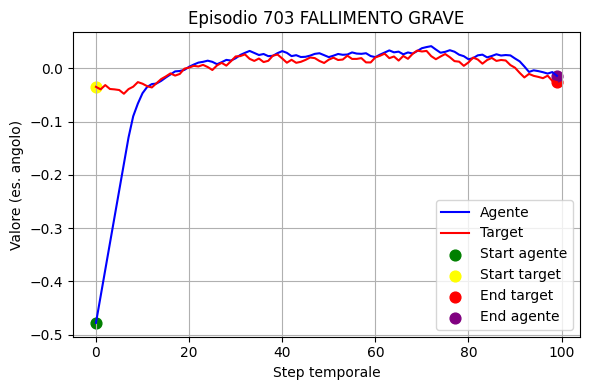

[Episode 703] Steps: 100, Total attached: 65, Mean distance: 0.0220, Success: False
[Episode 704] Steps: 100, Total attached: 81, Mean distance: 0.0220, Success: True
Fail episode 705 with total attached: 57


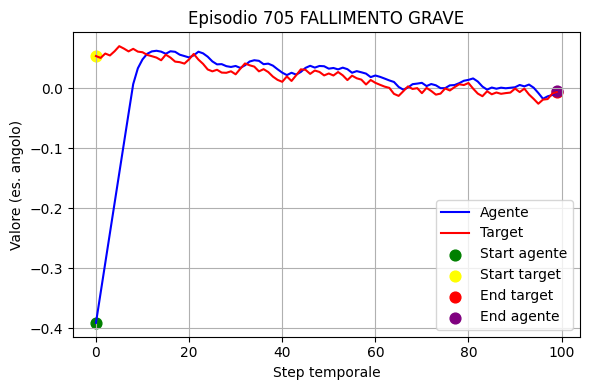

[Episode 705] Steps: 100, Total attached: 57, Mean distance: 0.0220, Success: False
[Episode 706] Steps: 100, Total attached: 74, Mean distance: 0.0220, Success: False
[Episode 707] Steps: 100, Total attached: 74, Mean distance: 0.0221, Success: False
[Episode 708] Steps: 100, Total attached: 97, Mean distance: 0.0221, Success: True
[Episode 709] Steps: 100, Total attached: 86, Mean distance: 0.0220, Success: True
[Episode 710] Steps: 100, Total attached: 91, Mean distance: 0.0220, Success: True
[Episode 711] Steps: 100, Total attached: 89, Mean distance: 0.0220, Success: True
[Episode 712] Steps: 100, Total attached: 90, Mean distance: 0.0220, Success: True
[Episode 713] Steps: 100, Total attached: 84, Mean distance: 0.0220, Success: True
[Episode 714] Steps: 100, Total attached: 71, Mean distance: 0.0221, Success: False
[Episode 715] Steps: 100, Total attached: 85, Mean distance: 0.0221, Success: True
[Episode 716] Steps: 100, Total attached: 86, Mean distance: 0.0221, Success: True


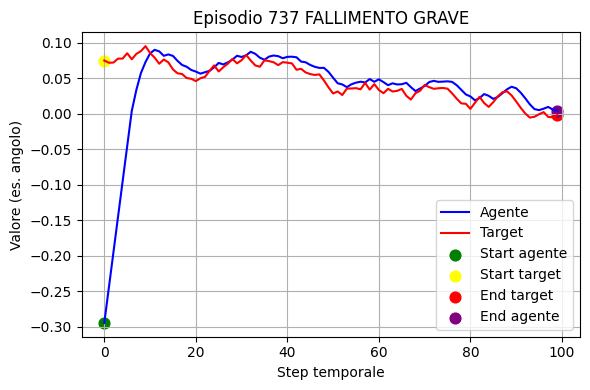

[Episode 737] Steps: 100, Total attached: 57, Mean distance: 0.0220, Success: False
[Episode 738] Steps: 100, Total attached: 75, Mean distance: 0.0220, Success: False
[Episode 739] Steps: 100, Total attached: 87, Mean distance: 0.0220, Success: True
[Episode 740] Steps: 100, Total attached: 92, Mean distance: 0.0220, Success: True
[Episode 741] Steps: 100, Total attached: 77, Mean distance: 0.0221, Success: False
[Episode 742] Steps: 100, Total attached: 91, Mean distance: 0.0220, Success: True
[Episode 743] Steps: 100, Total attached: 93, Mean distance: 0.0220, Success: True
[Episode 744] Steps: 100, Total attached: 73, Mean distance: 0.0220, Success: False
Fail episode 745 with total attached: 67


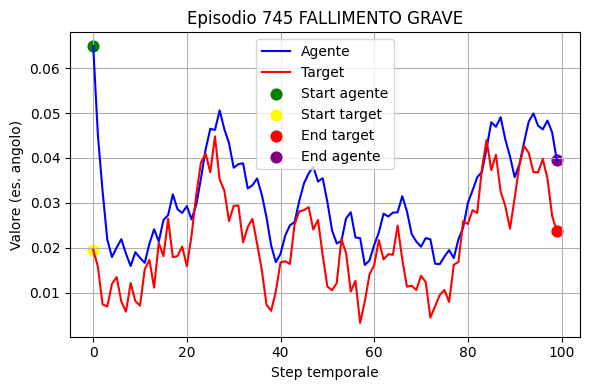

[Episode 745] Steps: 100, Total attached: 67, Mean distance: 0.0220, Success: False
[Episode 746] Steps: 100, Total attached: 86, Mean distance: 0.0220, Success: True
[Episode 747] Steps: 100, Total attached: 89, Mean distance: 0.0220, Success: True
[Episode 748] Steps: 100, Total attached: 95, Mean distance: 0.0220, Success: True
[Episode 749] Steps: 100, Total attached: 96, Mean distance: 0.0220, Success: True
Fail episode 750 with total attached: 64


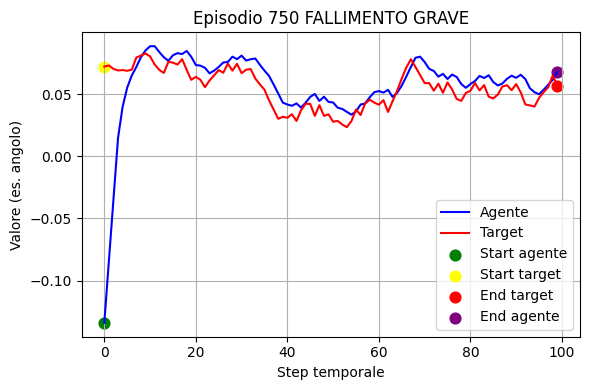

[Episode 750] Steps: 100, Total attached: 64, Mean distance: 0.0220, Success: False
[Episode 751] Steps: 100, Total attached: 79, Mean distance: 0.0220, Success: False
[Episode 752] Steps: 100, Total attached: 99, Mean distance: 0.0220, Success: True
[Episode 753] Steps: 100, Total attached: 72, Mean distance: 0.0221, Success: False
[Episode 754] Steps: 100, Total attached: 85, Mean distance: 0.0221, Success: True
[Episode 755] Steps: 100, Total attached: 77, Mean distance: 0.0220, Success: False
[Episode 756] Steps: 100, Total attached: 96, Mean distance: 0.0220, Success: True
[Episode 757] Steps: 100, Total attached: 72, Mean distance: 0.0220, Success: False
[Episode 758] Steps: 100, Total attached: 85, Mean distance: 0.0220, Success: True
[Episode 759] Steps: 100, Total attached: 82, Mean distance: 0.0220, Success: True
[Episode 760] Steps: 100, Total attached: 85, Mean distance: 0.0220, Success: True
[Episode 761] Steps: 100, Total attached: 84, Mean distance: 0.0220, Success: True

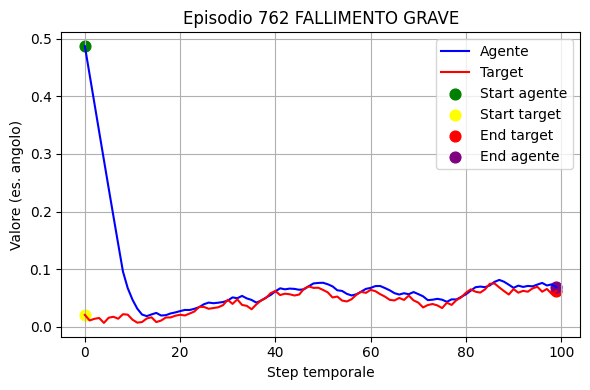

[Episode 762] Steps: 100, Total attached: 67, Mean distance: 0.0220, Success: False
[Episode 763] Steps: 100, Total attached: 77, Mean distance: 0.0221, Success: False
[Episode 764] Steps: 100, Total attached: 86, Mean distance: 0.0221, Success: True
[Episode 765] Steps: 100, Total attached: 90, Mean distance: 0.0220, Success: True
[Episode 766] Steps: 100, Total attached: 98, Mean distance: 0.0220, Success: True
[Episode 767] Steps: 100, Total attached: 85, Mean distance: 0.0220, Success: True
[Episode 768] Steps: 100, Total attached: 76, Mean distance: 0.0221, Success: False
[Episode 769] Steps: 100, Total attached: 80, Mean distance: 0.0221, Success: False
[Episode 770] Steps: 100, Total attached: 81, Mean distance: 0.0221, Success: True
[Episode 771] Steps: 100, Total attached: 80, Mean distance: 0.0221, Success: False
[Episode 772] Steps: 100, Total attached: 94, Mean distance: 0.0221, Success: True
[Episode 773] Steps: 100, Total attached: 86, Mean distance: 0.0221, Success: True

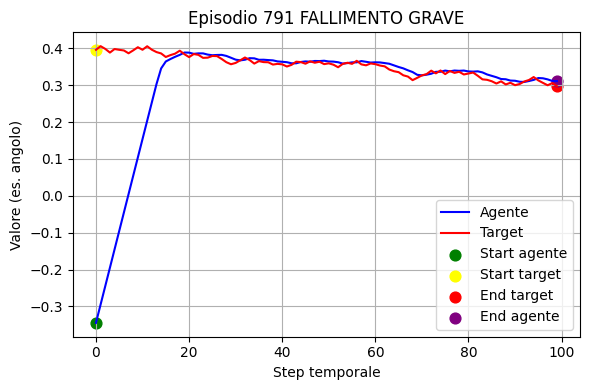

[Episode 791] Steps: 100, Total attached: 69, Mean distance: 0.0222, Success: False
[Episode 792] Steps: 100, Total attached: 92, Mean distance: 0.0222, Success: True
[Episode 793] Steps: 100, Total attached: 79, Mean distance: 0.0222, Success: False
[Episode 794] Steps: 100, Total attached: 96, Mean distance: 0.0222, Success: True
[Episode 795] Steps: 100, Total attached: 87, Mean distance: 0.0222, Success: True
[Episode 796] Steps: 100, Total attached: 93, Mean distance: 0.0222, Success: True
[Episode 797] Steps: 100, Total attached: 84, Mean distance: 0.0222, Success: True
[Episode 798] Steps: 100, Total attached: 100, Mean distance: 0.0222, Success: True
[Episode 799] Steps: 100, Total attached: 90, Mean distance: 0.0222, Success: True
[Episode 800] Steps: 100, Total attached: 75, Mean distance: 0.0222, Success: False


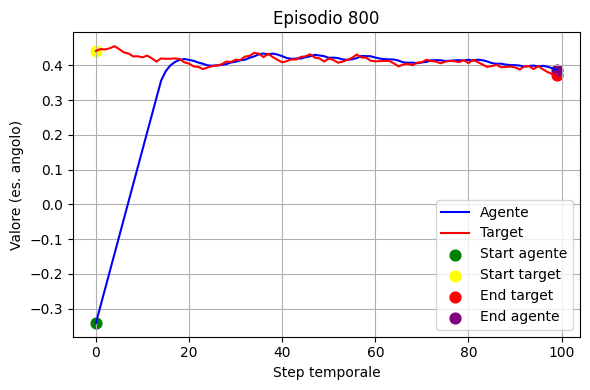

[Episode 801] Steps: 100, Total attached: 74, Mean distance: 0.0222, Success: False
[Episode 802] Steps: 100, Total attached: 96, Mean distance: 0.0222, Success: True
[Episode 803] Steps: 100, Total attached: 87, Mean distance: 0.0222, Success: True
[Episode 804] Steps: 100, Total attached: 87, Mean distance: 0.0222, Success: True
[Episode 805] Steps: 100, Total attached: 85, Mean distance: 0.0222, Success: True
[Episode 806] Steps: 100, Total attached: 77, Mean distance: 0.0223, Success: False
[Episode 807] Steps: 100, Total attached: 77, Mean distance: 0.0223, Success: False
[Episode 808] Steps: 100, Total attached: 73, Mean distance: 0.0222, Success: False
[Episode 809] Steps: 100, Total attached: 90, Mean distance: 0.0222, Success: True
[Episode 810] Steps: 100, Total attached: 78, Mean distance: 0.0222, Success: False
[Episode 811] Steps: 100, Total attached: 84, Mean distance: 0.0223, Success: True
[Episode 812] Steps: 100, Total attached: 89, Mean distance: 0.0222, Success: True

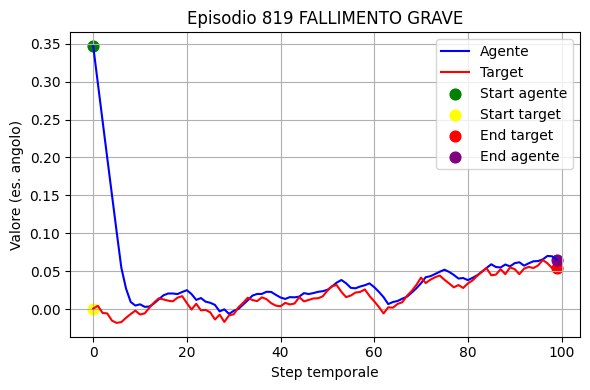

[Episode 819] Steps: 100, Total attached: 69, Mean distance: 0.0222, Success: False
[Episode 820] Steps: 100, Total attached: 86, Mean distance: 0.0222, Success: True
[Episode 821] Steps: 100, Total attached: 86, Mean distance: 0.0222, Success: True
[Episode 822] Steps: 100, Total attached: 82, Mean distance: 0.0222, Success: True
[Episode 823] Steps: 100, Total attached: 82, Mean distance: 0.0222, Success: True
[Episode 824] Steps: 100, Total attached: 92, Mean distance: 0.0222, Success: True
[Episode 825] Steps: 100, Total attached: 100, Mean distance: 0.0222, Success: True
[Episode 826] Steps: 100, Total attached: 84, Mean distance: 0.0223, Success: True
Fail episode 827 with total attached: 60


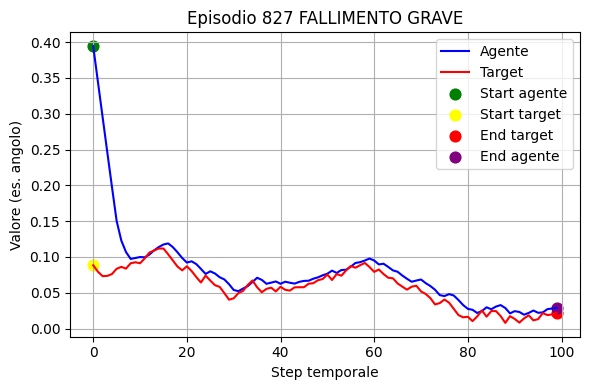

[Episode 827] Steps: 100, Total attached: 60, Mean distance: 0.0222, Success: False
[Episode 828] Steps: 100, Total attached: 87, Mean distance: 0.0223, Success: True
[Episode 829] Steps: 100, Total attached: 87, Mean distance: 0.0223, Success: True
[Episode 830] Steps: 100, Total attached: 94, Mean distance: 0.0223, Success: True
[Episode 831] Steps: 100, Total attached: 91, Mean distance: 0.0223, Success: True
[Episode 832] Steps: 100, Total attached: 85, Mean distance: 0.0222, Success: True
[Episode 833] Steps: 100, Total attached: 88, Mean distance: 0.0223, Success: True
[Episode 834] Steps: 100, Total attached: 85, Mean distance: 0.0223, Success: True
[Episode 835] Steps: 100, Total attached: 90, Mean distance: 0.0223, Success: True
[Episode 836] Steps: 100, Total attached: 84, Mean distance: 0.0223, Success: True
Fail episode 837 with total attached: 66


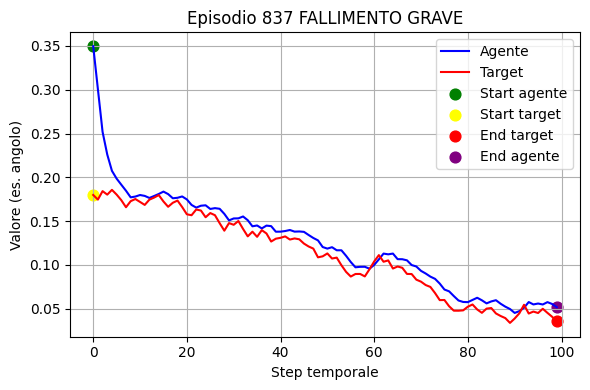

[Episode 837] Steps: 100, Total attached: 66, Mean distance: 0.0222, Success: False
[Episode 838] Steps: 100, Total attached: 90, Mean distance: 0.0222, Success: True
[Episode 839] Steps: 100, Total attached: 73, Mean distance: 0.0223, Success: False
[Episode 840] Steps: 100, Total attached: 72, Mean distance: 0.0222, Success: False
[Episode 841] Steps: 100, Total attached: 90, Mean distance: 0.0222, Success: True
[Episode 842] Steps: 100, Total attached: 95, Mean distance: 0.0222, Success: True
[Episode 843] Steps: 100, Total attached: 98, Mean distance: 0.0222, Success: True
[Episode 844] Steps: 100, Total attached: 90, Mean distance: 0.0222, Success: True
[Episode 845] Steps: 100, Total attached: 88, Mean distance: 0.0222, Success: True
[Episode 846] Steps: 100, Total attached: 89, Mean distance: 0.0222, Success: True
[Episode 847] Steps: 100, Total attached: 96, Mean distance: 0.0222, Success: True
[Episode 848] Steps: 100, Total attached: 82, Mean distance: 0.0222, Success: True
[

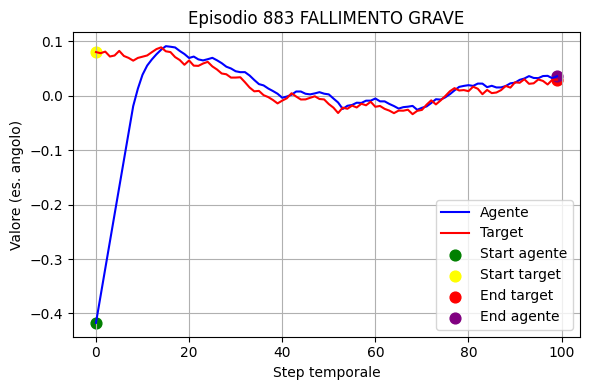

[Episode 883] Steps: 100, Total attached: 65, Mean distance: 0.0221, Success: False
[Episode 884] Steps: 100, Total attached: 88, Mean distance: 0.0222, Success: True
[Episode 885] Steps: 100, Total attached: 80, Mean distance: 0.0222, Success: False
[Episode 886] Steps: 100, Total attached: 96, Mean distance: 0.0222, Success: True
[Episode 887] Steps: 100, Total attached: 90, Mean distance: 0.0221, Success: True
[Episode 888] Steps: 100, Total attached: 88, Mean distance: 0.0221, Success: True
[Episode 889] Steps: 100, Total attached: 80, Mean distance: 0.0221, Success: False
Fail episode 890 with total attached: 63


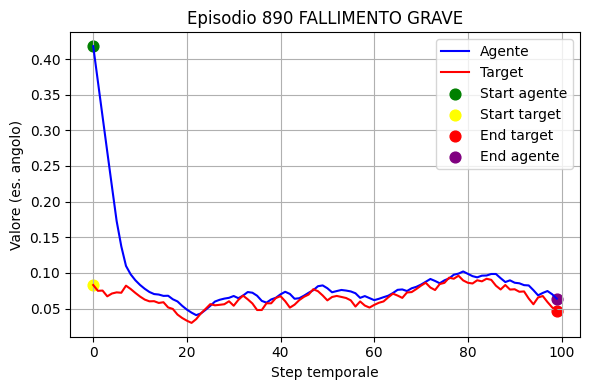

[Episode 890] Steps: 100, Total attached: 63, Mean distance: 0.0221, Success: False
[Episode 891] Steps: 100, Total attached: 74, Mean distance: 0.0221, Success: False
[Episode 892] Steps: 100, Total attached: 91, Mean distance: 0.0221, Success: True
[Episode 893] Steps: 100, Total attached: 99, Mean distance: 0.0221, Success: True
[Episode 894] Steps: 100, Total attached: 83, Mean distance: 0.0221, Success: True
[Episode 895] Steps: 100, Total attached: 73, Mean distance: 0.0222, Success: False
[Episode 896] Steps: 100, Total attached: 90, Mean distance: 0.0222, Success: True
[Episode 897] Steps: 100, Total attached: 84, Mean distance: 0.0222, Success: True
[Episode 898] Steps: 100, Total attached: 83, Mean distance: 0.0222, Success: True
[Episode 899] Steps: 100, Total attached: 75, Mean distance: 0.0222, Success: False
Fail episode 900 with total attached: 63


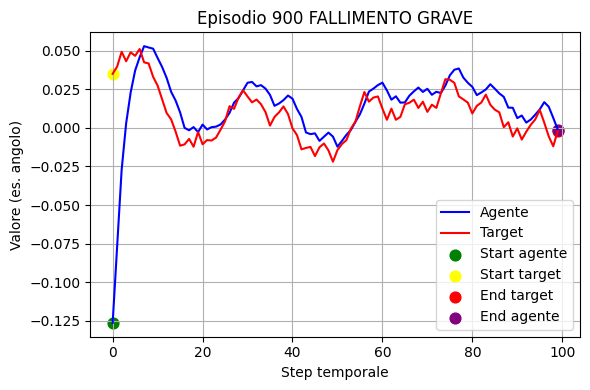

[Episode 900] Steps: 100, Total attached: 63, Mean distance: 0.0222, Success: False


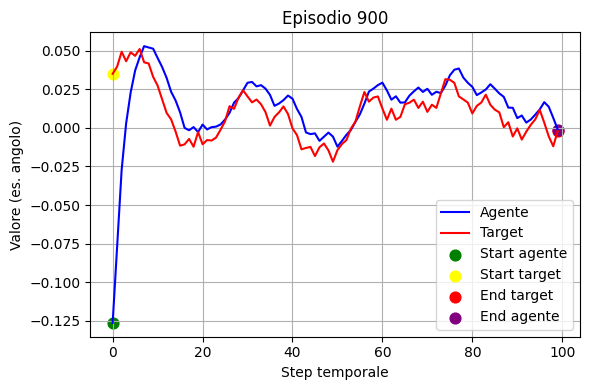

[Episode 901] Steps: 100, Total attached: 79, Mean distance: 0.0222, Success: False
[Episode 902] Steps: 100, Total attached: 93, Mean distance: 0.0222, Success: True
[Episode 903] Steps: 100, Total attached: 92, Mean distance: 0.0221, Success: True
[Episode 904] Steps: 100, Total attached: 79, Mean distance: 0.0222, Success: False
[Episode 905] Steps: 100, Total attached: 92, Mean distance: 0.0222, Success: True
[Episode 906] Steps: 100, Total attached: 70, Mean distance: 0.0222, Success: False
[Episode 907] Steps: 100, Total attached: 80, Mean distance: 0.0222, Success: False
[Episode 908] Steps: 100, Total attached: 82, Mean distance: 0.0222, Success: True
[Episode 909] Steps: 100, Total attached: 88, Mean distance: 0.0222, Success: True
[Episode 910] Steps: 100, Total attached: 89, Mean distance: 0.0222, Success: True
[Episode 911] Steps: 100, Total attached: 81, Mean distance: 0.0222, Success: True
[Episode 912] Steps: 100, Total attached: 98, Mean distance: 0.0222, Success: True


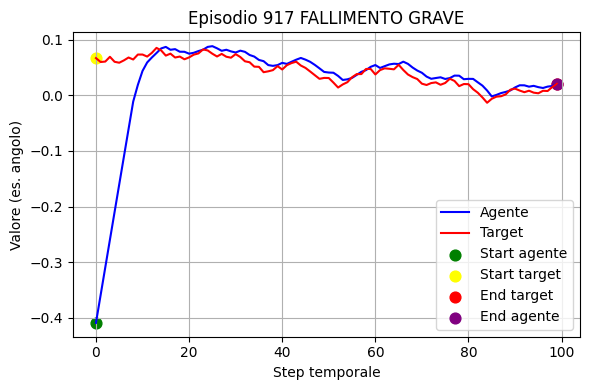

[Episode 917] Steps: 100, Total attached: 59, Mean distance: 0.0222, Success: False
[Episode 918] Steps: 100, Total attached: 92, Mean distance: 0.0222, Success: True
Fail episode 919 with total attached: 69


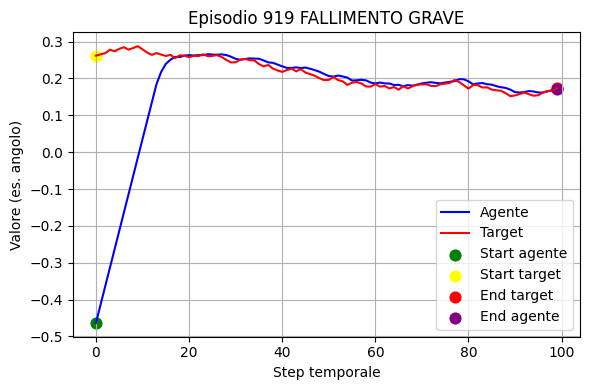

[Episode 919] Steps: 100, Total attached: 69, Mean distance: 0.0222, Success: False
[Episode 920] Steps: 100, Total attached: 95, Mean distance: 0.0222, Success: True
[Episode 921] Steps: 100, Total attached: 90, Mean distance: 0.0222, Success: True
[Episode 922] Steps: 100, Total attached: 99, Mean distance: 0.0222, Success: True
[Episode 923] Steps: 100, Total attached: 81, Mean distance: 0.0222, Success: True
[Episode 924] Steps: 100, Total attached: 73, Mean distance: 0.0222, Success: False
[Episode 925] Steps: 100, Total attached: 91, Mean distance: 0.0222, Success: True
[Episode 926] Steps: 100, Total attached: 82, Mean distance: 0.0222, Success: True
[Episode 927] Steps: 100, Total attached: 86, Mean distance: 0.0222, Success: True
[Episode 928] Steps: 100, Total attached: 79, Mean distance: 0.0222, Success: False
[Episode 929] Steps: 100, Total attached: 94, Mean distance: 0.0222, Success: True
[Episode 930] Steps: 100, Total attached: 79, Mean distance: 0.0221, Success: False


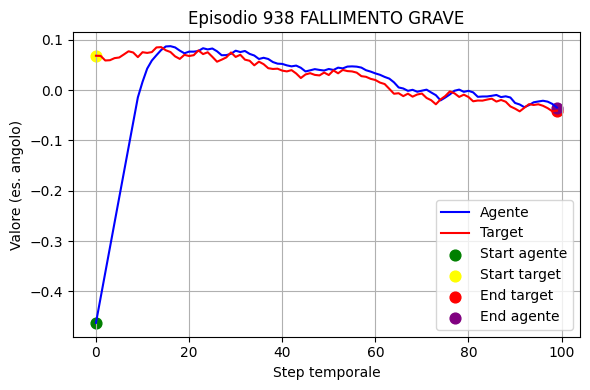

[Episode 938] Steps: 100, Total attached: 60, Mean distance: 0.0222, Success: False
[Episode 939] Steps: 100, Total attached: 89, Mean distance: 0.0222, Success: True
[Episode 940] Steps: 100, Total attached: 97, Mean distance: 0.0222, Success: True
[Episode 941] Steps: 100, Total attached: 76, Mean distance: 0.0222, Success: False
[Episode 942] Steps: 100, Total attached: 90, Mean distance: 0.0222, Success: True
[Episode 943] Steps: 100, Total attached: 88, Mean distance: 0.0222, Success: True
[Episode 944] Steps: 100, Total attached: 91, Mean distance: 0.0222, Success: True
[Episode 945] Steps: 100, Total attached: 83, Mean distance: 0.0222, Success: True
[Episode 946] Steps: 100, Total attached: 95, Mean distance: 0.0222, Success: True
[Episode 947] Steps: 100, Total attached: 89, Mean distance: 0.0222, Success: True
[Episode 948] Steps: 100, Total attached: 82, Mean distance: 0.0222, Success: True
[Episode 949] Steps: 100, Total attached: 78, Mean distance: 0.0222, Success: False
[

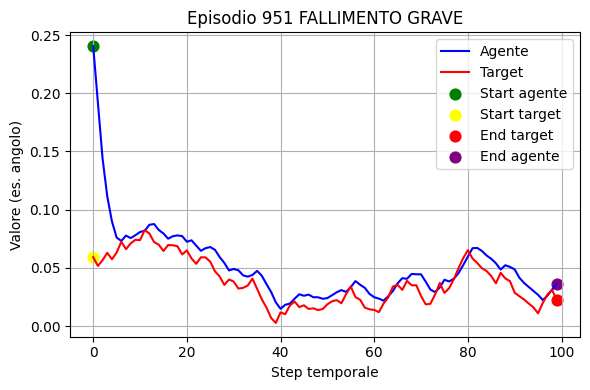

[Episode 951] Steps: 100, Total attached: 58, Mean distance: 0.0222, Success: False
[Episode 952] Steps: 100, Total attached: 97, Mean distance: 0.0221, Success: True
[Episode 953] Steps: 100, Total attached: 94, Mean distance: 0.0221, Success: True
[Episode 954] Steps: 100, Total attached: 75, Mean distance: 0.0221, Success: False
[Episode 955] Steps: 100, Total attached: 96, Mean distance: 0.0221, Success: True
[Episode 956] Steps: 100, Total attached: 81, Mean distance: 0.0222, Success: True
Fail episode 957 with total attached: 65


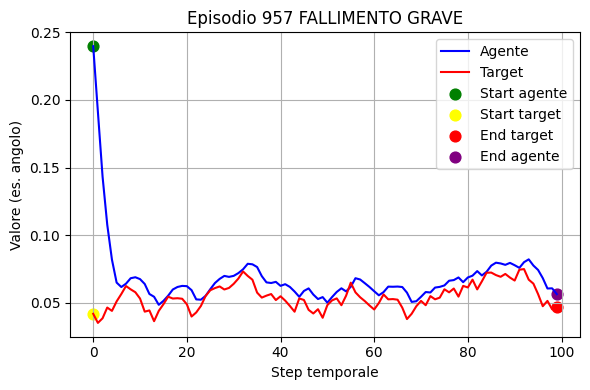

[Episode 957] Steps: 100, Total attached: 65, Mean distance: 0.0222, Success: False
[Episode 958] Steps: 100, Total attached: 72, Mean distance: 0.0222, Success: False
[Episode 959] Steps: 100, Total attached: 78, Mean distance: 0.0222, Success: False
[Episode 960] Steps: 100, Total attached: 70, Mean distance: 0.0222, Success: False
[Episode 961] Steps: 100, Total attached: 96, Mean distance: 0.0221, Success: True
[Episode 962] Steps: 100, Total attached: 89, Mean distance: 0.0221, Success: True
[Episode 963] Steps: 100, Total attached: 88, Mean distance: 0.0221, Success: True
[Episode 964] Steps: 100, Total attached: 71, Mean distance: 0.0221, Success: False
[Episode 965] Steps: 100, Total attached: 85, Mean distance: 0.0221, Success: True
[Episode 966] Steps: 100, Total attached: 96, Mean distance: 0.0221, Success: True
[Episode 967] Steps: 100, Total attached: 96, Mean distance: 0.0221, Success: True
[Episode 968] Steps: 100, Total attached: 94, Mean distance: 0.0221, Success: True

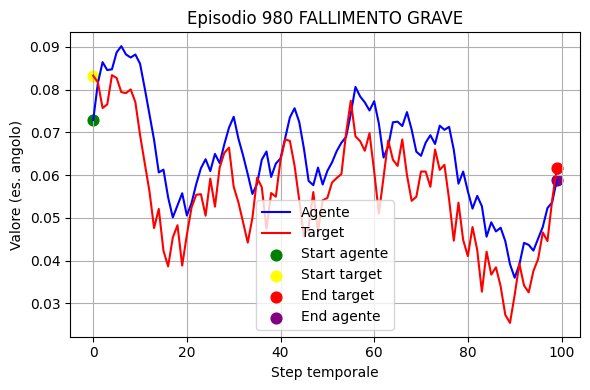

[Episode 980] Steps: 100, Total attached: 67, Mean distance: 0.0222, Success: False
Fail episode 981 with total attached: 58


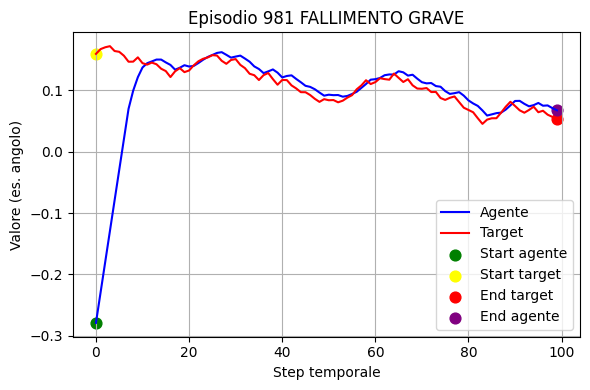

[Episode 981] Steps: 100, Total attached: 58, Mean distance: 0.0222, Success: False
[Episode 982] Steps: 100, Total attached: 80, Mean distance: 0.0222, Success: False
[Episode 983] Steps: 100, Total attached: 87, Mean distance: 0.0222, Success: True
[Episode 984] Steps: 100, Total attached: 89, Mean distance: 0.0222, Success: True
[Episode 985] Steps: 100, Total attached: 75, Mean distance: 0.0222, Success: False
[Episode 986] Steps: 100, Total attached: 88, Mean distance: 0.0222, Success: True
[Episode 987] Steps: 100, Total attached: 80, Mean distance: 0.0222, Success: False
[Episode 988] Steps: 100, Total attached: 80, Mean distance: 0.0222, Success: False
[Episode 989] Steps: 100, Total attached: 82, Mean distance: 0.0222, Success: True
[Episode 990] Steps: 100, Total attached: 93, Mean distance: 0.0222, Success: True
[Episode 991] Steps: 100, Total attached: 95, Mean distance: 0.0222, Success: True
[Episode 992] Steps: 100, Total attached: 87, Mean distance: 0.0222, Success: True

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    device = torch.device("cpu")
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path, map_location=device))
    reward_net.to(device)
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=1000, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []
    fail = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.abs(real_next_state[0] - real_state[1])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        if total_attached_counter < 70:
            fail += 1
            print(f"Fail episode {ep} with total attached: {total_attached_counter}")
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep} FALLIMENTO GRAVE")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep}")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")
    print(f"Fallimenti gravi (attaccato < 70 step): {fail} / {num_episodes}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_rot_0.5_0.01_init_"
    reward_path = "IL/DME_SAC/reward_network_rot_0.5_0.01.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)
